This notebook implements different predictive models to predict the hemolytic activity of peptides based on sequence-based properties.

#### Set working directory

In [1]:
import os
os.chdir('/Users/fabienplisson/Desktop/MODELS/')
print(os.getcwd())

/Users/fabienplisson/Desktop/MODELS


#### Modules

In [2]:
import os
import rdkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
import sklearn

In [3]:
from os import path

from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

#### Loading HemoPI datasets

In [4]:
HemoPI1_model = pd.read_csv('./Data/HemoPI1_model.csv', index_col=0)
HemoPI1_validation = pd.read_csv('./Data/HemoPI1_validation.csv', index_col=0)

In [5]:
HemoPI2_model = pd.read_csv('./Data/HemoPI2_model.csv', index_col=0)
HemoPI2_validation = pd.read_csv('./Data/HemoPI2_validation.csv', index_col=0)

In [6]:
HemoPI3_model = pd.read_csv('./Data/HemoPI3_model.csv', index_col=0)
HemoPI3_validation = pd.read_csv('./Data/HemoPI3_validation.csv', index_col=0)

#### Save Hemolytik datasets as 3 fasta files

In [7]:
HemoPI1 = pd.concat([HemoPI1_model, HemoPI1_validation], axis=0)
HemoPI2 = pd.concat([HemoPI2_model, HemoPI2_validation], axis=0)
HemoPI3 = pd.concat([HemoPI3_model, HemoPI3_validation], axis=0)

In [8]:
HemoPI1.shape

(1104, 60)

In [9]:
def fasta_converter(database):
    '''Use the indices of the database and the column 'Sequence' to create a fasta file'''
    #ofile = open('/Users/fabienplisson/Desktop/MODELS/Data/HemoPI1.fasta', "w")
    #ofile = open('/Users/fabienplisson/Desktop/MODELS/Data/HemoPI2.fasta', "w")
    ofile = open('/Users/fabienplisson/Desktop/MODELS/Data/HemoPI3.fasta', "w")

    for i in range(len(database.Sequence)):

        ofile.write(">" + database.index[i] + "\n" +database.Sequence[i] + "\n")
        
    ofile.close()

In [10]:
fasta_converter(HemoPI3)

#### Cleaning dataset

- Remove columns with NA values

In [11]:
cleaned_HemoPI1_model = HemoPI1_model.dropna(axis='columns')
cleaned_HemoPI1_model.shape

(884, 59)

In [12]:
cleaned_HemoPI1_validation = HemoPI1_validation.dropna(axis='columns')
cleaned_HemoPI1_validation.shape

(220, 59)

In [13]:
cleaned_HemoPI2_model = HemoPI2_model.dropna(axis='columns')
cleaned_HemoPI2_model.shape

(812, 59)

In [14]:
cleaned_HemoPI2_validation = HemoPI2_validation.dropna(axis='columns')
cleaned_HemoPI2_validation.shape

(202, 59)

In [15]:
cleaned_HemoPI3_model = HemoPI3_model.dropna(axis='columns')
cleaned_HemoPI3_model.shape

(1298, 59)

In [16]:
cleaned_HemoPI3_validation = HemoPI3_validation.dropna(axis='columns')
cleaned_HemoPI3_validation.shape

(325, 59)

In [17]:
cleaned_HemoPI1_model.columns

Index([u'Sequence', u'H_Eisenberg', u'uH_Eisenberg', u'H_GRAVY', u'uH_GRAVY',
       u'Z3_1', u'Z3_2', u'Z3_3', u' Z5_1', u'Z5_2', u'Z5_3', u' Z5_4',
       u'Z5_5', u'S_AASI', u' uS_AASI', u' modlas_ABHPRK', u' H_argos',
       u' uH_argos', u' B_Builkiness', u' uB_Builkiness', u' charge_phys',
       u' charge_acid', u' Ez', u' flexibility', u' u_flexibility',
       u' Grantham', u' H_HoppWoods', u' uH-HoppWoods', u' ISAECI',
       u' H_Janin', u' uH_Janin', u' H_KyteDoolittle', u' uH_KyteDoolittle',
       u' F_Levitt', u' uF_Levitt', u' MSS_shape', u' u_MSS_shape', u' MSW',
       u' pepArc', u' pepcats', u' polarity', u' u_polarity', u' PPCALI',
       u' refractivity', u' u_refractivity', u' t_scale', u' TM_tend',
       u' u_TM_tend', u' Sequence', u'Length', u'BomanIndex', u'Aromaticity',
       u'AliphaticIndex', u'InstabilityIndex', u' NetCharge', u' MW',
       u' IsoelectricPoint', u' HydrophobicRatio', u'y_model_2cl'],
      dtype='object')

- Remove duplicated columns

In [18]:
# Sequence and Sequence are identical - remove both columns (Sequence,  Sequence)
# Remove class column prior normalization
cleaned_HemoPI1_model = cleaned_HemoPI1_model.drop(['Sequence',' Sequence', 'y_model_2cl'], axis=1)
cleaned_HemoPI1_validation = cleaned_HemoPI1_validation.drop(['Sequence',' Sequence', 'y_validation_2cl'], axis=1)
cleaned_HemoPI2_model = cleaned_HemoPI2_model.drop(['Sequence',' Sequence', 'y_model_2cl'], axis=1)
cleaned_HemoPI2_validation = cleaned_HemoPI2_validation.drop(['Sequence',' Sequence', 'y_validation_2cl'], axis=1)
cleaned_HemoPI3_model = cleaned_HemoPI3_model.drop(['Sequence',' Sequence', 'y_model_2cl'], axis=1)
cleaned_HemoPI3_validation = cleaned_HemoPI3_validation.drop(['Sequence',' Sequence', 'y_validation_2cl'], axis=1)

In [19]:
print cleaned_HemoPI1_model.shape
print cleaned_HemoPI1_validation.shape
print cleaned_HemoPI2_model.shape
print cleaned_HemoPI2_validation.shape
print cleaned_HemoPI3_model.shape
print cleaned_HemoPI3_validation.shape

(884, 56)
(220, 56)
(812, 56)
(202, 56)
(1298, 56)
(325, 56)


- Normalize datasets

In [20]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [21]:
norm_HemoPI1_model = normalize(cleaned_HemoPI1_model)
norm_HemoPI1_validation = normalize(cleaned_HemoPI1_validation)
norm_HemoPI2_model = normalize(cleaned_HemoPI2_model)
norm_HemoPI2_validation = normalize(cleaned_HemoPI2_validation)
norm_HemoPI3_model = normalize(cleaned_HemoPI3_model)
norm_HemoPI3_validation = normalize(cleaned_HemoPI3_validation)

- Remove descriptors with high collinearity

In [22]:
# Create correlation matrix
corr_matrix = norm_HemoPI1_model.corr()
corr_matrix

,H_Eisenberg,uH_Eisenberg,H_GRAVY,uH_GRAVY,Z3_1,Z3_2,Z3_3,Z5_1,Z5_2,Z5_3,...,u_TM_tend,Length,BomanIndex,Aromaticity,AliphaticIndex,InstabilityIndex,NetCharge,MW,IsoelectricPoint,HydrophobicRatio
H_Eisenberg,1.000000,0.006218,0.889938,0.167809,0.217921,0.179892,-0.580800,0.135828,0.157186,-0.520160,...,0.091984,-0.016710,-0.922374,-0.090046,0.628723,-0.275935,-0.263243,-0.107942,-0.147791,0.686882
uH_Eisenberg,0.006218,1.000000,0.154846,0.931205,0.607865,-0.135547,0.176180,0.551147,-0.097778,0.168849,...,0.933421,-0.320635,-0.173678,0.210791,0.391122,-0.274313,0.401666,-0.266267,0.451366,0.237923
H_GRAVY,0.889938,0.154846,1.000000,0.289916,0.244031,0.117415,-0.268843,0.193465,0.133143,-0.167764,...,0.184979,-0.061188,-0.879047,-0.134800,0.751326,-0.285285,-0.032514,-0.138084,0.046363,0.894970
uH_GRAVY,0.167809,0.931205,0.289916,1.000000,0.614002,-0.140773,0.054372,0.544449,-0.140968,0.051239,...,0.937580,-0.320605,-0.317191,0.125626,0.493420,-0.317818,0.308046,-0.284901,0.358755,0.342766
Z3_1,0.217921,0.607865,0.244031,0.614002,1.000000,-0.240783,-0.020873,0.938978,-0.188457,-0.017438,...,0.642256,-0.280980,-0.334002,0.439005,0.513779,-0.229134,0.222078,-0.197580,0.290027,0.279503
Z3_2,0.179892,-0.135547,0.117415,-0.140773,-0.240783,1.000000,-0.050571,-0.242861,0.913045,0.009362,...,-0.210348,0.108802,-0.090337,-0.012739,-0.140135,-0.009469,0.010098,0.050685,0.075741,-0.109832
Z3_3,-0.580800,0.176180,-0.268843,0.054372,-0.020873,-0.050571,1.000000,0.022774,0.057258,0.961137,...,0.084996,-0.080551,0.397788,0.242039,-0.269008,0.119625,0.476406,-0.004531,0.336028,-0.092128
Z5_1,0.135828,0.551147,0.193465,0.544449,0.938978,-0.242861,0.022774,1.000000,-0.176918,0.074770,...,0.557078,-0.298065,-0.205734,0.395105,0.514510,-0.085314,0.122402,-0.201984,0.190104,0.217145
Z5_2,0.157186,-0.097778,0.133143,-0.140968,-0.188457,0.913045,0.057258,-0.176918,1.000000,0.135182,...,-0.218445,0.055601,-0.060465,0.229339,-0.181928,0.073655,0.065054,0.028394,0.137252,-0.021883
Z5_3,-0.520160,0.168849,-0.167764,0.051239,-0.017438,0.009362,0.961137,0.074770,0.135182,1.000000,...,0.031994,-0.101044,0.401743,0.229839,-0.201861,0.229777,0.418700,-0.025598,0.315634,-0.015655


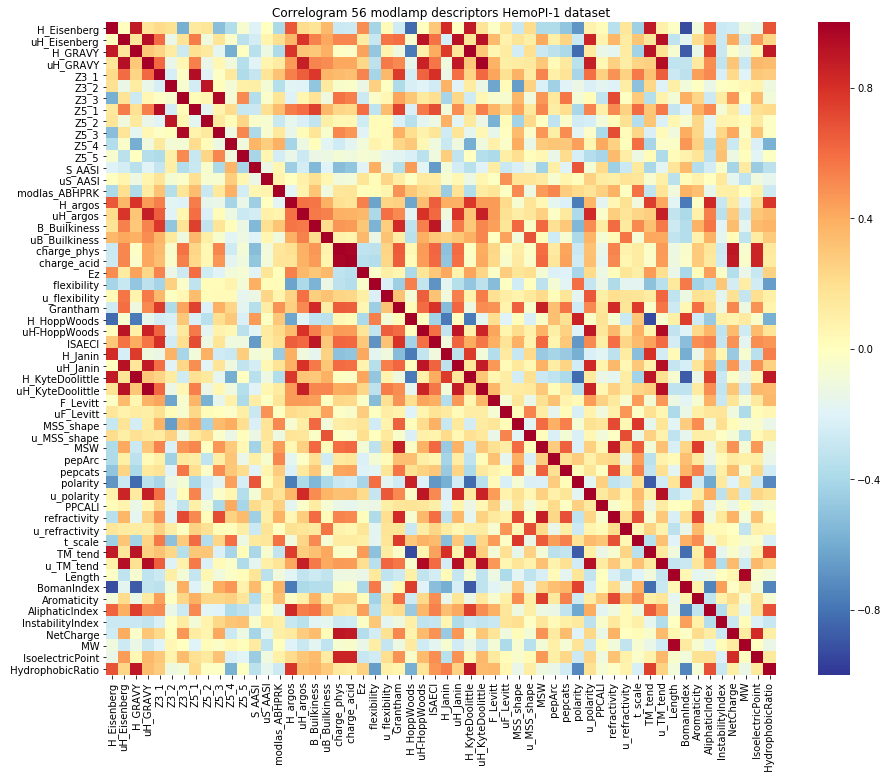

In [24]:
import seaborn as sns
figpath = "./Figures/HemoPeps/"
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=False, cmap=plt.cm.RdYlBu_r, vmax=1.0, vmin=-1.0)
plt.title("Correlogram 56 modlamp descriptors HemoPI-1 dataset")
#plt.savefig(path.join(figpath, "Correlogram 56 modlamp descriptors HemoPI-1 dataset.pdf"))
#plt.close()
plt.show()

In [25]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
to_drop

['H_GRAVY',
 'uH_GRAVY',
 ' Z5_1',
 'Z5_2',
 'Z5_3',
 ' H_argos',
 ' uH_argos',
 ' B_Builkiness',
 ' charge_acid',
 ' Grantham',
 ' uH-HoppWoods',
 ' ISAECI',
 ' H_Janin',
 ' uH_Janin',
 ' H_KyteDoolittle',
 ' uH_KyteDoolittle',
 ' MSW',
 ' polarity',
 ' u_polarity',
 ' refractivity',
 ' t_scale',
 ' TM_tend',
 ' u_TM_tend',
 'BomanIndex',
 'Aromaticity',
 'AliphaticIndex',
 ' NetCharge',
 ' MW',
 ' IsoelectricPoint',
 ' HydrophobicRatio']

In [25]:
# Drop features 
trim_HemoPI1_model = norm_HemoPI1_model.drop(norm_HemoPI1_model[to_drop], axis=1)
trim_HemoPI1_model.shape

(884, 26)

#### HemoPI-2 dataset

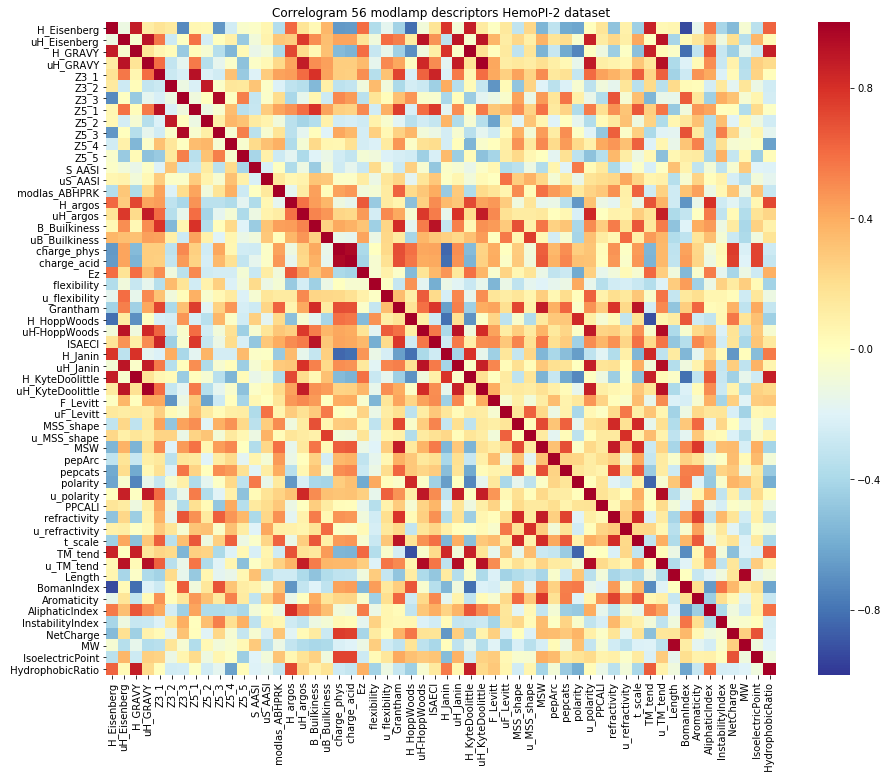

In [26]:
# Create correlation matrix
corr_matrix2 = norm_HemoPI2_model.corr()

figpath = "/Users/fabienplisson/Desktop/MODELS/Figures/HemoPeps/"
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix2, annot=False, cmap=plt.cm.RdYlBu_r, vmax=1.0, vmin=-1.0)
plt.title("Correlogram 56 modlamp descriptors HemoPI-2 dataset")
#plt.savefig(path.join(figpath, "Correlogram 56 modlamp descriptors HemoPI-2 dataset.pdf"))
#plt.close()
plt.show()

In [27]:
# Select upper triangle of correlation matrix
upper = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
to_drop

# Drop features 
trim_HemoPI2_model = norm_HemoPI2_model.drop(norm_HemoPI2_model[to_drop], axis=1)
trim_HemoPI2_model.shape

(812, 27)

#### HemoPI-3 dataset

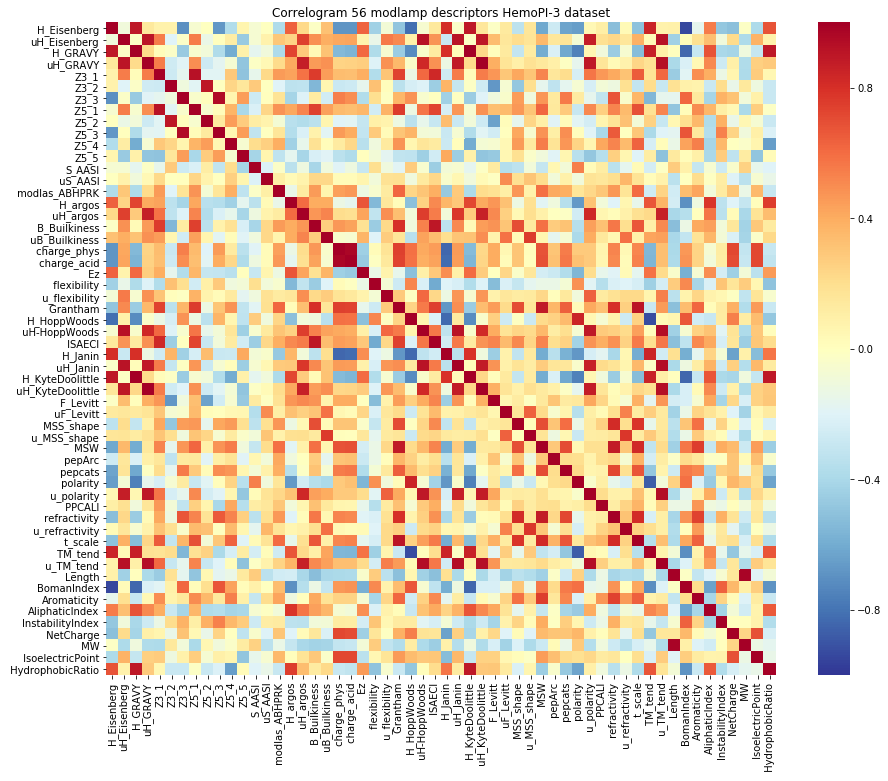

In [28]:
# Create correlation matrix
corr_matrix3 = norm_HemoPI3_model.corr()

figpath = "./Figures/HemoPeps/"
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix3, annot=False, cmap=plt.cm.RdYlBu_r, vmax=1.0, vmin=-1.0)
plt.title("Correlogram 56 modlamp descriptors HemoPI-3 dataset")
#plt.savefig(path.join(figpath, "Correlogram 56 modlamp descriptors HemoPI-3 dataset.pdf"))
#plt.close()
plt.show()

In [29]:
# Create correlation matrix
corr_matrix3 = norm_HemoPI3_model.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix3.where(np.triu(np.ones(corr_matrix3.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
to_drop

# Drop features 
trim_HemoPI3_model = norm_HemoPI3_model.drop(norm_HemoPI3_model[to_drop], axis=1)
trim_HemoPI3_model.shape

(1298, 28)

##### Define X and y of model and validation datasets

In [30]:
X_HemoPI1_model = norm_HemoPI1_model
X_HemoPI1_validation = norm_HemoPI1_validation 
X_HemoPI2_model = norm_HemoPI2_model 
X_HemoPI2_validation = norm_HemoPI2_validation 
X_HemoPI3_model = norm_HemoPI3_model 
X_HemoPI3_validation = norm_HemoPI3_validation 

In [31]:
y_HemoPI1_model = HemoPI1_model['y_model_2cl']
y_HemoPI1_validation = HemoPI1_validation['y_validation_2cl'] 
y_HemoPI2_model = HemoPI2_model['y_model_2cl'] 
y_HemoPI2_validation = HemoPI2_validation['y_validation_2cl'] 
y_HemoPI3_model = HemoPI3_model['y_model_2cl'] 
y_HemoPI3_validation = HemoPI3_validation['y_validation_2cl'] 

In [32]:
from os import path
from sklearn import metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score, matthews_corrcoef, average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

In [35]:
seed=42

In [36]:
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle= True)

In [37]:
skfold = model_selection.StratifiedKFold(n_splits=10, random_state=seed, shuffle= True)

#### Running basic binary models

In [38]:
models = []
models.append(('logreg', LogisticRegression(fit_intercept=True)))
models.append(('knn', KNeighborsClassifier()))
models.append(('cart', DecisionTreeClassifier(random_state=seed)))
models.append(('rfc', RandomForestClassifier(random_state=seed, max_depth=5, n_jobs=10)))
models.append(('gbc', GradientBoostingClassifier(random_state=seed)))
models.append(('adc', AdaBoostClassifier()))
models.append(('lda', LinearDiscriminantAnalysis()))
models.append(('qda', QuadraticDiscriminantAnalysis()))
models.append(('nb', GaussianNB()))
models.append(('svc_lr', SVC(kernel="linear", C=0.025)))
models.append(('svc_rbf', SVC(probability=True)))
models.append(('svc_poly', SVC(kernel="poly", probability=True)))
models.append(('svc_sig', SVC(kernel="sigmoid", probability=True)))

HemoPI-1 dataset

logreg: Accuracy Score 92.65% (2.68%)
logreg: Accuracy 92.65%
logreg: Precision-Recall 89.39%
logreg: Matthews Coefficient 85.30%
logreg: Cohen Kappa Score 85.29%
logreg: ROC AUC Score 92.65%
             precision    recall  f1-score   support

      low 0       0.93      0.92      0.93       442
     high 1       0.92      0.93      0.93       442

avg / total       0.93      0.93      0.93       884

logreg: Accuracy 89.55%
logreg: Precision-Recall 84.73%
logreg: Matthews Coefficient 79.17%
logreg: Cohen Kappa Score 79.09%
logreg: ROC AUC Score 89.55%
             precision    recall  f1-score   support

      low 0       0.91      0.87      0.89       110
     high 1       0.88      0.92      0.90       110

avg / total       0.90      0.90      0.90       220

knn: Accuracy Score 93.22% (3.22%)
knn: Accuracy 93.21%
knn: Precision-Recall 89.63%
knn: Matthews Coefficient 86.48%
knn: Cohen Kappa Score 86.43%
knn: ROC AUC Score 93.21%
             precision    recall  f1-score   suppo

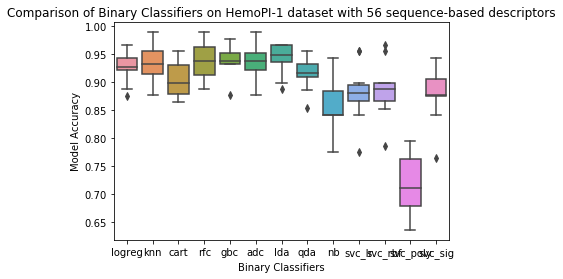

In [52]:
results = []
names = []

for name, model in models:
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI1_model, y_HemoPI1_model, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI1_model, y_HemoPI1_model, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_model, cv_preds)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI1_validation, y_HemoPI1_validation, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_validation, cv_preds2)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   
        
fig = sns.boxplot(data=results)
fig.set_xticklabels(names)
fig.set_title('Comparison of Binary Classifiers on HemoPI-1 dataset with 56 sequence-based descriptors')
plt.xlabel('Binary Classifiers')
plt.ylabel('Model Accuracy')
plt.show()
#plt.savefig(path.join(figpath, "Figure3.1_Comparison of Binary Classifiers with 200 descriptors.pdf"))
#plt.close()

HemoPI-2 dataset

Both model and validation datasets (HemoPI-2 and HemoPI-3) are not balanced. We need to take that unbalance into consideration with 10-fold stratified cross-validation while computing binary classifiers.

logreg: Accuracy Score 67.99% (5.23%)
logreg: Accuracy 67.98%
logreg: Precision-Recall 65.21%
logreg: Matthews Coefficient 35.03%
logreg: Cohen Kappa Score 34.79%
logreg: ROC AUC Score 67.22%
             precision    recall  f1-score   support

      low 0       0.67      0.59      0.63       370
     high 1       0.69      0.76      0.72       442

avg / total       0.68      0.68      0.68       812

logreg: Accuracy 65.84%
logreg: Precision-Recall 63.21%
logreg: Matthews Coefficient 30.53%
logreg: Cohen Kappa Score 29.83%
logreg: ROC AUC Score 64.63%
             precision    recall  f1-score   support

      low 0       0.66      0.51      0.58        92
     high 1       0.66      0.78      0.71       110

avg / total       0.66      0.66      0.65       202

knn: Accuracy Score 71.56% (3.20%)
knn: Accuracy 71.55%
knn: Precision-Recall 68.07%
knn: Matthews Coefficient 42.35%
knn: Cohen Kappa Score 42.10%
knn: ROC AUC Score 70.85%
             precision    recall  f1-score   suppo

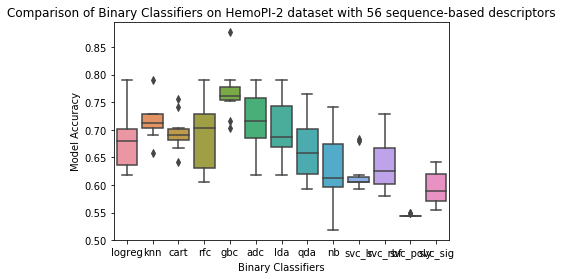

In [53]:
results = []
names = []

for name, model in models:
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI2_model, y_HemoPI2_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI2_model, y_HemoPI2_model, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI2_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_model, cv_preds)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI2_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI2_validation, y_HemoPI2_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_validation, cv_preds2)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI2_validation, cv_preds2, target_names=target_names))
   
        
fig = sns.boxplot(data=results)
fig.set_xticklabels(names)
fig.set_title('Comparison of Binary Classifiers on HemoPI-2 dataset with 56 sequence-based descriptors')
plt.xlabel('Binary Classifiers')
plt.ylabel('Model Accuracy')
plt.show()
#plt.savefig(path.join(figpath, "Figure3.1_Comparison of Binary Classifiers with 200 descriptors.pdf"))
#plt.close()

HemoPI-3 dataset

logreg: Accuracy Score 69.72% (2.09%)
logreg: Accuracy 69.72%
logreg: Precision-Recall 66.11%
logreg: Matthews Coefficient 38.65%
logreg: Cohen Kappa Score 37.75%
logreg: ROC AUC Score 68.52%
             precision    recall  f1-score   support

      low 0       0.72      0.55      0.62       590
     high 1       0.69      0.82      0.75       708

avg / total       0.70      0.70      0.69      1298

logreg: Accuracy 70.77%
logreg: Precision-Recall 66.95%
logreg: Matthews Coefficient 40.83%
logreg: Cohen Kappa Score 40.04%
logreg: ROC AUC Score 69.68%
             precision    recall  f1-score   support

      low 0       0.73      0.57      0.64       148
     high 1       0.70      0.82      0.75       177

avg / total       0.71      0.71      0.70       325

knn: Accuracy Score 72.80% (4.11%)
knn: Accuracy 72.80%
knn: Precision-Recall 69.35%
knn: Matthews Coefficient 44.90%
knn: Cohen Kappa Score 44.74%
knn: ROC AUC Score 72.20%
             precision    recall  f1-score   suppo

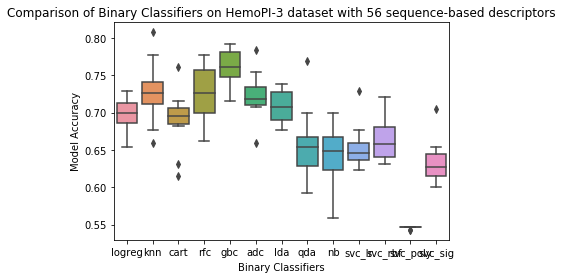

In [54]:
results = []
names = []

for name, model in models:
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI3_model, y_HemoPI3_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI3_model, y_HemoPI3_model, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI3_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_model, cv_preds)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI3_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI3_validation, y_HemoPI3_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_validation, cv_preds2)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI3_validation, cv_preds2, target_names=target_names))
   
        
fig = sns.boxplot(data=results)
fig.set_xticklabels(names)
fig.set_title('Comparison of Binary Classifiers on HemoPI-3 dataset with 56 sequence-based descriptors')
plt.xlabel('Binary Classifiers')
plt.ylabel('Model Accuracy')
plt.show()
#plt.savefig(path.join(figpath, "Figure3.1_Comparison of Binary Classifiers with 200 descriptors.pdf"))
#plt.close()

Among binary classifiers for HemoPI-1, -2 and -3 datasets, GBC is the best performer with model accuracies 94/76.7/76% and validation accuracies 90.4/72.3/72.9%.

#### Filtering variables (descriptors) with Recursive Feature Elimination (RFE) to best models 
RFECV does not work with SVM kernel RBF (only linear))

In [93]:
top_models = []
top_models.append(('logreg', LogisticRegression(fit_intercept=True)))
top_models.append(('rfc', RandomForestClassifier(random_state=seed)))
top_models.append(('gbc', GradientBoostingClassifier(random_state=seed)))
top_models.append(('lda', LinearDiscriminantAnalysis()))
top_models.append(('svc_rbf', SVC(probability=True)))

In [74]:
from sklearn.feature_selection import RFECV

HemoPI-1 dataset

In [95]:
results = []
names = []

for name, model in top_models:
    
    # Apply RFECV
    rfecv_model = RFECV(model, step=1, cv=kfold)
    rfecv = rfecv_model.fit(X_HemoPI1_model, y_HemoPI1_model)
    X_HemoPI1_model_RFE = rfecv.transform(X_HemoPI1_model)
    X_HemoPI1_val_RFE = rfecv.transform(X_HemoPI1_validation)
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI1_model_RFE, y_HemoPI1_model, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (rfecv.n_features_))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI1_model_RFE, y_HemoPI1_model, cv=kfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI1_val_RFE, y_HemoPI1_validation, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   
        

gbc: Accuracy Score 95.03% (2.53%)
Optimal number of features : 31

gbc: Precision-Recall 92.78%
gbc: Matthews Coefficient 90.05%
gbc: Cohen Kappa Score 90.05%
gbc: ROC AUC Score 95.02%

gbc: Accuracy 90.45%
gbc: Precision-Recall 86.45%
gbc: Matthews Coefficient 80.91%
gbc: Cohen Kappa Score 80.91%
gbc: ROC AUC Score 90.45%



HemoPI-2 dataset

In [65]:
results = []
names = []

for name, model in top_models:
    
    # Apply RFECV
    rfecv_model = RFECV(model, step=1, cv=skfold)
    rfecv = rfecv_model.fit(X_HemoPI2_model, y_HemoPI2_model)
    X_HemoPI2_model_RFE = rfecv.transform(X_HemoPI2_model)
    X_HemoPI2_val_RFE = rfecv.transform(X_HemoPI2_validation)
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI2_model_RFE, y_HemoPI2_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (rfecv.n_features_))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI2_model_RFE, y_HemoPI2_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI2_val_RFE, y_HemoPI2_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   
        

rfc: Accuracy Score 72.79% (4.60%)
Optimal number of features : 34

rfc: Precision-Recall 70.79%
rfc: Matthews Coefficient 45.96%
rfc: Cohen Kappa Score 45.67%
rfc: ROC AUC Score 73.06%

rfc: Accuracy 69.80%
rfc: Precision-Recall 68.26%
rfc: Matthews Coefficient 40.15%
rfc: Cohen Kappa Score 39.82%
rfc: ROC AUC Score 70.14%

gbc: Accuracy Score 77.84% (2.99%)
Optimal number of features : 15

gbc: Precision-Recall 74.21%
gbc: Matthews Coefficient 55.22%
gbc: Cohen Kappa Score 55.20%
gbc: ROC AUC Score 77.52%

gbc: Accuracy 73.27%
gbc: Precision-Recall 69.84%
gbc: Matthews Coefficient 45.90%
gbc: Cohen Kappa Score 45.82%
gbc: ROC AUC Score 72.79%

adc: Accuracy Score 74.26% (3.39%)
Optimal number of features : 24

adc: Precision-Recall 70.56%
adc: Matthews Coefficient 47.90%
adc: Cohen Kappa Score 47.76%
adc: ROC AUC Score 73.72%

adc: Accuracy 65.84%
adc: Precision-Recall 64.04%
adc: Matthews Coefficient 30.97%
adc: Cohen Kappa Score 30.95%
adc: ROC AUC Score 65.43%

lda: Accuracy Score

HemoPI-3 dataset

In [66]:
results = []
names = []

for name, model in top_models:
    
    # Apply RFECV
    rfecv_model = RFECV(model, step=1, cv=skfold)
    rfecv = rfecv_model.fit(X_HemoPI3_model, y_HemoPI3_model)
    X_HemoPI3_model_RFE = rfecv.transform(X_HemoPI3_model)
    X_HemoPI3_val_RFE = rfecv.transform(X_HemoPI3_validation)
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI3_model_RFE, y_HemoPI3_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (rfecv.n_features_))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI3_model_RFE, y_HemoPI3_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI3_val_RFE, y_HemoPI3_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   
        

rfc: Accuracy Score 75.03% (3.62%)
Optimal number of features : 22

rfc: Precision-Recall 72.35%
rfc: Matthews Coefficient 49.91%
rfc: Cohen Kappa Score 49.86%
rfc: ROC AUC Score 75.03%

rfc: Accuracy 69.23%
rfc: Precision-Recall 67.11%
rfc: Matthews Coefficient 38.20%
rfc: Cohen Kappa Score 38.17%
rfc: ROC AUC Score 69.15%

gbc: Accuracy Score 75.73% (2.37%)
Optimal number of features : 55

gbc: Precision-Recall 71.83%
gbc: Matthews Coefficient 50.87%
gbc: Cohen Kappa Score 50.66%
gbc: ROC AUC Score 75.13%

gbc: Accuracy 72.00%
gbc: Precision-Recall 68.71%
gbc: Matthews Coefficient 43.31%
gbc: Cohen Kappa Score 43.20%
gbc: ROC AUC Score 71.47%

adc: Accuracy Score 72.57% (2.72%)
Optimal number of features : 12

adc: Precision-Recall 68.95%
adc: Matthews Coefficient 44.41%
adc: Cohen Kappa Score 44.12%
adc: ROC AUC Score 71.84%

adc: Accuracy 68.62%
adc: Precision-Recall 65.59%
adc: Matthews Coefficient 36.30%
adc: Cohen Kappa Score 35.95%
adc: ROC AUC Score 67.75%

lda: Accuracy Score

#### Filtering descriptors using Backward Elimination 

In [446]:
top_models = []
top_models.append(('logreg', LogisticRegression(fit_intercept=True)))
top_models.append(('rfc', RandomForestClassifier(random_state=seed)))
top_models.append(('gbc', GradientBoostingClassifier(random_state=seed)))
top_models.append(('lda', LinearDiscriminantAnalysis()))
top_models.append(('svc_rbf', SVC(probability=True)))

HemoPI-1 dataset

In [451]:
import statsmodels.api as sm

X_1 = sm.add_constant(X_HemoPI1_model)

#Fitting sm.OLS model
model = sm.OLS(y_HemoPI1_model,X_1).fit()
model.pvalues

const                3.749423e-05
H_Eisenberg          6.752051e-01
uH_Eisenberg         2.680693e-01
H_GRAVY              1.224396e-03
uH_GRAVY             6.926257e-01
Z3_1                 9.282889e-04
Z3_2                 6.619114e-01
Z3_3                 9.779918e-03
 Z5_1                4.319115e-01
Z5_2                 2.225203e-01
Z5_3                 2.787501e-03
 Z5_4                8.416010e-01
Z5_5                 1.043847e-01
S_AASI               2.809502e-01
 uS_AASI             1.508249e-02
 modlas_ABHPRK       4.289635e-02
 H_argos             4.723534e-03
 uH_argos            2.956799e-01
 B_Builkiness        4.223052e-08
 uB_Builkiness       1.822707e-03
 charge_phys         6.520904e-01
 charge_acid         4.129462e-01
 Ez                  1.026665e-01
 flexibility         4.717868e-02
 u_flexibility       6.146913e-02
 Grantham            2.283128e-02
 H_HoppWoods         4.821138e-01
 uH-HoppWoods        3.788767e-01
 ISAECI              2.288481e-05
 H_Janin      

In [452]:
cols = list(X_HemoPI1_model.columns)
pmax = 1

while (len(cols)>0):
    p= []
    X_1 = X_HemoPI1_model[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_HemoPI1_model,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print selected_features_BE

['Z3_1', 'Z5_2', ' uS_AASI', ' modlas_ABHPRK', ' B_Builkiness', ' uB_Builkiness', ' u_flexibility', ' H_HoppWoods', ' ISAECI', ' uH_Janin', ' F_Levitt', ' MSS_shape', ' u_MSS_shape', ' refractivity', ' t_scale', ' u_TM_tend', 'Length', 'BomanIndex', 'Aromaticity', 'AliphaticIndex', ' NetCharge', ' MW', ' IsoelectricPoint']


In [453]:
X_HemoPI1_model_BE = X_HemoPI1_model[selected_features_BE]
X_HemoPI1_val_BE = X_HemoPI1_validation[selected_features_BE]

In [454]:
results = []
names = []

for name, model in top_models:
    
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI1_model_BE, y_HemoPI1_model, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (len(selected_features_BE)))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI1_model_BE, y_HemoPI1_model, cv=kfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI1_val_BE, y_HemoPI1_validation, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   
        

rfc: Accuracy Score 93.67% (2.41%)
Optimal number of features : 23

rfc: Precision-Recall 91.80%
rfc: Matthews Coefficient 87.42%
rfc: Cohen Kappa Score 87.33%
rfc: ROC AUC Score 93.67%

rfc: Accuracy 85.91%
rfc: Precision-Recall 81.46%
rfc: Matthews Coefficient 71.89%
rfc: Cohen Kappa Score 71.82%
rfc: ROC AUC Score 85.91%

gbc: Accuracy Score 94.46% (3.20%)
Optimal number of features : 23

gbc: Precision-Recall 92.13%
gbc: Matthews Coefficient 88.92%
gbc: Cohen Kappa Score 88.91%
gbc: ROC AUC Score 94.46%

gbc: Accuracy 89.09%
gbc: Precision-Recall 85.71%
gbc: Matthews Coefficient 78.30%
gbc: Cohen Kappa Score 78.18%
gbc: ROC AUC Score 89.09%

lda: Accuracy Score 94.12% (2.89%)
Optimal number of features : 23

lda: Precision-Recall 91.01%
lda: Matthews Coefficient 88.27%
lda: Cohen Kappa Score 88.24%
lda: ROC AUC Score 94.12%

lda: Accuracy 93.64%
lda: Precision-Recall 91.21%
lda: Matthews Coefficient 87.29%
lda: Cohen Kappa Score 87.27%
lda: ROC AUC Score 93.64%



HemoPI-2 dataset

In [455]:
import statsmodels.api as sm

X_1 = sm.add_constant(X_HemoPI2_model)

#Fitting sm.OLS model
model = sm.OLS(y_HemoPI2_model,X_1).fit()
model.pvalues

const                0.576001
H_Eisenberg          0.142720
uH_Eisenberg         0.752683
H_GRAVY              0.719462
uH_GRAVY             0.217019
Z3_1                 0.045691
Z3_2                 0.095312
Z3_3                 0.051957
 Z5_1                0.024312
Z5_2                 0.002830
Z5_3                 0.017842
 Z5_4                0.873265
Z5_5                 0.017324
S_AASI               0.005040
 uS_AASI             0.043334
 modlas_ABHPRK       0.192662
 H_argos             0.934322
 uH_argos            0.330768
 B_Builkiness        0.056720
 uB_Builkiness       0.107908
 charge_phys         0.987171
 charge_acid         0.029209
 Ez                  0.830124
 flexibility         0.341358
 u_flexibility       0.076846
 Grantham            0.058629
 H_HoppWoods         0.074685
 uH-HoppWoods        0.024668
 ISAECI              0.892434
 H_Janin             0.402711
 uH_Janin            0.156244
 H_KyteDoolittle     0.808418
 uH_KyteDoolittle    0.417382
 F_Levitt 

In [456]:
cols = list(X_HemoPI2_model.columns)
pmax = 1

while (len(cols)>0):
    p= []
    X_1 = X_HemoPI2_model[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_HemoPI2_model,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print selected_features_BE

['uH_GRAVY', 'Z3_3', 'S_AASI', ' uS_AASI', ' B_Builkiness', ' uB_Builkiness', ' u_flexibility', ' Grantham', ' uH-HoppWoods', ' uF_Levitt', ' u_MSS_shape', ' MSW', ' TM_tend', ' u_TM_tend', ' MW', ' IsoelectricPoint']


In [457]:
X_HemoPI2_model_BE = X_HemoPI2_model[selected_features_BE]
X_HemoPI2_val_BE = X_HemoPI2_validation[selected_features_BE]

In [458]:
results = []
names = []

for name, model in top_models:
    
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI2_model_BE, y_HemoPI2_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (len(selected_features_BE)))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI2_model_BE, y_HemoPI2_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI2_val_BE, y_HemoPI2_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   
        

rfc: Accuracy Score 74.88% (6.23%)
Optimal number of features : 16

rfc: Precision-Recall 72.46%
rfc: Matthews Coefficient 49.87%
rfc: Cohen Kappa Score 49.71%
rfc: ROC AUC Score 75.03%

rfc: Accuracy 64.85%
rfc: Precision-Recall 63.59%
rfc: Matthews Coefficient 29.34%
rfc: Cohen Kappa Score 29.33%
rfc: ROC AUC Score 64.70%

gbc: Accuracy Score 74.26% (4.64%)
Optimal number of features : 16

gbc: Precision-Recall 70.45%
gbc: Matthews Coefficient 47.89%
gbc: Cohen Kappa Score 47.69%
gbc: ROC AUC Score 73.65%

gbc: Accuracy 68.81%
gbc: Precision-Recall 65.99%
gbc: Matthews Coefficient 36.77%
gbc: Cohen Kappa Score 36.62%
gbc: ROC AUC Score 68.16%

lda: Accuracy Score 70.09% (5.35%)
Optimal number of features : 16

lda: Precision-Recall 66.54%
lda: Matthews Coefficient 39.34%
lda: Cohen Kappa Score 38.77%
lda: ROC AUC Score 69.10%

lda: Accuracy 65.35%
lda: Precision-Recall 62.82%
lda: Matthews Coefficient 29.49%
lda: Cohen Kappa Score 28.74%
lda: ROC AUC Score 64.09%



HemoPI-3 dataset

In [84]:
import statsmodels.api as sm

X_1 = sm.add_constant(X_HemoPI3_model)

#Fitting sm.OLS model
model = sm.OLS(y_HemoPI3_model,X_1).fit()
model.pvalues

const                0.000134
H_Eisenberg          0.165076
uH_Eisenberg         0.588407
H_GRAVY              0.325153
uH_GRAVY             0.279928
Z3_1                 0.229263
Z3_2                 0.041047
Z3_3                 0.318791
 Z5_1                0.007984
Z5_2                 0.009601
Z5_3                 0.216351
 Z5_4                0.008761
Z5_5                 0.958637
S_AASI               0.348265
 uS_AASI             0.554425
 modlas_ABHPRK       0.006019
 H_argos             0.063589
 uH_argos            0.691364
 B_Builkiness        0.607749
 uB_Builkiness       0.226105
 charge_phys         0.103523
 charge_acid         0.834881
 Ez                  0.001341
 flexibility         0.058778
 u_flexibility       0.062569
 Grantham            0.009879
 H_HoppWoods         0.539139
 uH-HoppWoods        0.321634
 ISAECI              0.027810
 H_Janin             0.216097
 uH_Janin            0.181324
 H_KyteDoolittle     0.266479
 uH_KyteDoolittle    0.382379
 F_Levitt 

In [85]:
cols = list(X_HemoPI3_model.columns)
pmax = 1

while (len(cols)>0):
    p= []
    X_1 = X_HemoPI3_model[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_HemoPI3_model,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print selected_features_BE

['Z3_1', 'Z3_2', 'Z3_3', ' Z5_1', 'S_AASI', ' modlas_ABHPRK', ' uB_Builkiness', ' Ez', ' flexibility', ' Grantham', ' ISAECI', ' H_KyteDoolittle', ' MSS_shape', ' u_TM_tend', 'AliphaticIndex', 'InstabilityIndex', ' NetCharge', ' MW']


In [86]:
X_HemoPI3_model_BE = X_HemoPI3_model[selected_features_BE]
X_HemoPI3_val_BE = X_HemoPI3_validation[selected_features_BE]

In [87]:
results = []
names = []

for name, model in top_models:
    
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI3_model_BE, y_HemoPI3_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (len(selected_features_BE)))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI3_model_BE, y_HemoPI3_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI3_val_BE, y_HemoPI3_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   
        

rfc: Accuracy Score 74.35% (2.31%)
Optimal number of features : 18

rfc: Precision-Recall 71.69%
rfc: Matthews Coefficient 48.50%
rfc: Cohen Kappa Score 48.46%
rfc: ROC AUC Score 74.32%

rfc: Accuracy 65.85%
rfc: Precision-Recall 64.23%
rfc: Matthews Coefficient 31.18%
rfc: Cohen Kappa Score 31.18%
rfc: ROC AUC Score 65.60%

gbc: Accuracy Score 74.42% (2.38%)
Optimal number of features : 18

gbc: Precision-Recall 70.63%
gbc: Matthews Coefficient 48.19%
gbc: Cohen Kappa Score 47.96%
gbc: ROC AUC Score 73.77%

gbc: Accuracy 69.23%
gbc: Precision-Recall 66.49%
gbc: Matthews Coefficient 37.70%
gbc: Cohen Kappa Score 37.62%
gbc: ROC AUC Score 68.71%

svc_rbf: Accuracy Score 65.41% (3.43%)
Optimal number of features : 18

svc_rbf: Precision-Recall 62.30%
svc_rbf: Matthews Coefficient 30.16%
svc_rbf: Cohen Kappa Score 27.76%
svc_rbf: ROC AUC Score 63.40%

svc_rbf: Accuracy 64.62%
svc_rbf: Precision-Recall 61.25%
svc_rbf: Matthews Coefficient 29.97%
svc_rbf: Cohen Kappa Score 25.23%
svc_rbf: R

Regardless of the method for feature elimination, LDA is the best binary classifier for HemoPI-1 dataset while GBC is the best model with other datasets (HemoPI-2, HemoPI-3) 

#### Searching optimised models

- Search functions for each model's hyperparameters

In [302]:
seed=42

In [303]:
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle= True)

- Logistic Regression

In [194]:
logreg = LogisticRegression(random_state=seed, fit_intercept=True)

def logreg_param_selection(X, y, fold):
    param_grid = { 
        #'penalty' : ['l1'],
        'penalty' : ['l2'],
        'C' : [0.1, 1, 10, 100, 1000],
        'tol' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        #'solver': ['liblinear', 'saga']
        'solver': ['newton-cg', 'lbfgs', 'sag']
    }

    grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=fold)
    grid_search.fit(X, y)
    return grid_search.best_params_

- Random Forest Classifier

In [304]:
rfc = RandomForestClassifier(random_state=seed)

def rfc_param_selection(X, y, fold):
    param_grid = { 
        'n_estimators' : filter(lambda x: x % 25 == 0, list(range(25,300))),
        'max_depth': filter(lambda x: x % 2 == 0, list(range(2,40))),
        'min_samples_leaf': filter(lambda x: x % 2 == 0, list(range(2,10))),
        'max_features': [None, 'sqrt', 'log2']}

    grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=fold)
    grid_search.fit(X, y)
    return grid_search.best_params_

- Gradient Boosting Classifier

In [95]:
gbc = GradientBoostingClassifier(random_state=seed) 

def gbc_param_selection(X, y, fold):
    param_grid = { 
        'n_estimators' : filter(lambda x: x % 100 == 0, list(range(100,1000))),
        'max_depth': filter(lambda x: x % 2 == 0, list(range(2,40))),
        'min_samples_leaf': filter(lambda x: x % 2 == 0, list(range(2,10))),
        'max_features': [None, 'sqrt', 'log2']}

    grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=fold)
    grid_search.fit(X, y)
    return grid_search.best_params_

- Linear Discriminant Analysis

In [96]:
lda = LinearDiscriminantAnalysis() 

def lda_param_selection(X, y, fold):
    param_grid = {'solver': ['svd', 'lsqr'], 
                  'tol' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
                 }
    
    grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=fold)
    grid_search.fit(X, y)
    return grid_search.best_params_

- Support Vector Machine 

In [119]:
svc_rbf = SVC(kernel='rbf', probability=True) 

def svc_param_selection(X, y, fold):
    param_grid = { 
        'C' : [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

    grid_search = GridSearchCV(estimator=svc_rbf, param_grid=param_grid, cv=fold)
    grid_search.fit(X, y)
    return grid_search.best_params_

- Tuning hyperparameters of binary classifiers for HemoPI-1 dataset

With all modlamp descriptors

In [41]:
# Hyperparameters were searched on institutional server Mazorka
logreg_param_selection(X_HemoPI1_model, y_HemoPI1_model, kfold)
rfc_param_selection(X_HemoPI1_model, y_HemoPI1_model, kfold)
gbc_param_selection(X_HemoPI1_model, y_HemoPI1_model, kfold)
lda_param_selection(X_HemoPI1_model, y_HemoPI1_model, kfold)
svc_param_selection(X_HemoPI1_model, y_HemoPI1_model, kfold)

In [459]:
opt_models = []
opt_models.append(('logreg', LogisticRegression(C=1000, penalty='l2', solver='newton-cg', tol=0.1, random_state=seed, fit_intercept=True)))
opt_models.append(('rfc', RandomForestClassifier(n_estimators=208, max_depth=14, min_samples_leaf=2, max_features='log2', random_state=seed, n_jobs=-1)))
opt_models.append(('gbc', GradientBoostingClassifier(n_estimators=240, max_depth=4, min_samples_leaf=10, max_features='sqrt', random_state=seed)))
opt_models.append(('lda', LinearDiscriminantAnalysis(solver='svd', tol=0.0001)))
opt_models.append(('svc_rbf', SVC(gamma=1, C=1, probability=True)))

In [460]:
results = []
names = []

for name, model in opt_models:
    
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI1_model, y_HemoPI1_model, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    #print("Optimal number of features : %d" % (len(selected_features_BE)))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI1_model, y_HemoPI1_model, cv=kfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_model, cv_preds)))
    print("")
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI1_validation, y_HemoPI1_validation, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_validation, cv_preds2)))
    print("")
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   
        

logreg: Accuracy Score 94.57% (3.07%)

logreg: Precision-Recall 92.06%
logreg: Matthews Coefficient 89.14%
logreg: Cohen Kappa Score 89.14%
logreg: ROC AUC Score 94.57%

             precision    recall  f1-score   support

      low 0       0.95      0.94      0.95       442
     high 1       0.94      0.95      0.95       442

avg / total       0.95      0.95      0.95       884

logreg: Accuracy 85.91%
logreg: Precision-Recall 80.73%
logreg: Matthews Coefficient 71.82%
logreg: Cohen Kappa Score 71.82%
logreg: ROC AUC Score 85.91%

             precision    recall  f1-score   support

      low 0       0.86      0.85      0.86       110
     high 1       0.86      0.86      0.86       110

avg / total       0.86      0.86      0.86       220

rfc: Accuracy Score 94.91% (2.94%)

rfc: Precision-Recall 92.76%
rfc: Matthews Coefficient 89.82%
rfc: Cohen Kappa Score 89.82%
rfc: ROC AUC Score 94.91%

             precision    recall  f1-score   support

      low 0       0.95      0.95    

With Multicollinearity (threshold - 0.75)

In [461]:
# Create correlation matrix
corr_matrix = norm_HemoPI1_model.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
to_drop

# Drop features 
trim_HemoPI1_model = norm_HemoPI1_model.drop(norm_HemoPI1_model[to_drop], axis=1)
trim_HemoPI1_val = norm_HemoPI1_validation.drop(norm_HemoPI1_validation[to_drop], axis=1)
print(trim_HemoPI1_model.shape, trim_HemoPI1_val.shape)

((884, 26), (220, 26))


In [464]:
#Before and after optimising hyperparameters
#top_models = []
#top_models.append(('logreg', LogisticRegression(fit_intercept=True)))
#top_models.append(('rfc', RandomForestClassifier(random_state=seed)))
#top_models.append(('gbc', GradientBoostingClassifier(random_state=seed)))
#top_models.append(('lda', LinearDiscriminantAnalysis()))
#top_models.append(('svc_rbf', SVC(probability=True)))


opt_models = []
opt_models.append(('logreg', LogisticRegression(C=1000, penalty='l2', solver='newton-cg', tol=0.1, random_state=seed, fit_intercept=True)))
opt_models.append(('rfc', RandomForestClassifier(n_estimators=208, max_depth=14, min_samples_leaf=2, max_features='log2', random_state=seed, n_jobs=-1)))
opt_models.append(('gbc', GradientBoostingClassifier(n_estimators=240, max_depth=4, min_samples_leaf=10, max_features='sqrt', random_state=seed)))
opt_models.append(('lda', LinearDiscriminantAnalysis(solver='svd', tol=0.0001)))
opt_models.append(('svc_rbf', SVC(gamma=1, C=1, probability=True)))

In [465]:
results = []
names = []

for name, model in opt_models:
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, trim_HemoPI1_model, y_HemoPI1_model, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, trim_HemoPI1_model, y_HemoPI1_model, cv=kfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, trim_HemoPI1_val, y_HemoPI1_validation, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   

logreg: Accuracy Score 94.01% (3.14%)

logreg: Precision-Recall 91.24%
logreg: Matthews Coefficient 88.01%
logreg: Cohen Kappa Score 88.01%
logreg: ROC AUC Score 94.00%

logreg: Accuracy 89.55%
logreg: Precision-Recall 85.85%
logreg: Matthews Coefficient 79.12%
logreg: Cohen Kappa Score 79.09%
logreg: ROC AUC Score 89.55%

rfc: Accuracy Score 94.80% (2.58%)

rfc: Precision-Recall 92.56%
rfc: Matthews Coefficient 89.59%
rfc: Cohen Kappa Score 89.59%
rfc: ROC AUC Score 94.80%

rfc: Accuracy 89.09%
rfc: Precision-Recall 85.11%
rfc: Matthews Coefficient 78.19%
rfc: Cohen Kappa Score 78.18%
rfc: ROC AUC Score 89.09%

gbc: Accuracy Score 96.50% (2.53%)

gbc: Precision-Recall 95.01%
gbc: Matthews Coefficient 92.99%
gbc: Cohen Kappa Score 92.99%
gbc: ROC AUC Score 96.49%

gbc: Accuracy 92.73%
gbc: Precision-Recall 89.62%
gbc: Matthews Coefficient 85.45%
gbc: Cohen Kappa Score 85.45%
gbc: ROC AUC Score 92.73%

lda: Accuracy Score 93.44% (2.76%)

lda: Precision-Recall 90.17%
lda: Matthews Coeffi

With RFE-selected descriptors

In [340]:
opt_models = []
#opt_models.append(('logreg', LogisticRegression(C=1000, penalty='l2', solver='lbfgs', tol=0.1, random_state=seed, fit_intercept=True)))
opt_models.append(('rfc', RandomForestClassifier(n_estimators=48, max_depth=6, min_samples_leaf=4, max_features='log2', random_state=seed, n_jobs=-1)))
opt_models.append(('gbc', GradientBoostingClassifier(n_estimators=32, max_depth=16, min_samples_leaf=10, max_features='sqrt', random_state=seed)))
opt_models.append(('lda', LinearDiscriminantAnalysis(solver='svd', tol=0.0001)))
#opt_models.append(('svc_rbf', SVC(gamma=0.1, C=10, probability=True)))

In [341]:
results = []
names = []

for name, model in opt_models:
    
    rfecv_model = RFECV(model, step=1, cv=kfold)
    rfecv = rfecv_model.fit(X_HemoPI1_model, y_HemoPI1_model)
    X_HemoPI1_model_RFE = rfecv.transform(X_HemoPI1_model)
    X_HemoPI1_val_RFE = rfecv.transform(X_HemoPI1_validation)
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI1_model_RFE, y_HemoPI1_model, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % ((rfecv.n_features_)))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI1_model_RFE, y_HemoPI1_model, cv=kfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI1_val_RFE, y_HemoPI1_validation, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   
        

rfc: Accuracy Score 95.25% (2.30%)
Optimal number of features : 51

rfc: Precision-Recall 93.01%
rfc: Matthews Coefficient 90.50%
rfc: Cohen Kappa Score 90.50%
rfc: ROC AUC Score 95.25%

rfc: Accuracy 90.91%
rfc: Precision-Recall 87.19%
rfc: Matthews Coefficient 81.82%
rfc: Cohen Kappa Score 81.82%
rfc: ROC AUC Score 90.91%

gbc: Accuracy Score 95.14% (3.42%)
Optimal number of features : 25

gbc: Precision-Recall 92.99%
gbc: Matthews Coefficient 90.27%
gbc: Cohen Kappa Score 90.27%
gbc: ROC AUC Score 95.14%

gbc: Accuracy 90.00%
gbc: Precision-Recall 86.30%
gbc: Matthews Coefficient 80.01%
gbc: Cohen Kappa Score 80.00%
gbc: ROC AUC Score 90.00%

lda: Accuracy Score 95.14% (2.77%)
Optimal number of features : 18

lda: Precision-Recall 92.62%
lda: Matthews Coefficient 90.28%
lda: Cohen Kappa Score 90.27%
lda: ROC AUC Score 95.14%

lda: Accuracy 94.55%
lda: Precision-Recall 92.48%
lda: Matthews Coefficient 89.11%
lda: Cohen Kappa Score 89.09%
lda: ROC AUC Score 94.55%



With BE-selected descriptors

In [647]:
results = []
names = []

for name, model in opt_models:
    
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI1_model_BE, y_HemoPI1_model, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (len(selected_features_BE)))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI1_model_BE, y_HemoPI1_model, cv=kfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI1_val_BE, y_HemoPI1_validation, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   
        

gbc: Accuracy Score 95.48% (2.62%)
Optimal number of features : 18

gbc: Precision-Recall 93.51%
gbc: Matthews Coefficient 90.95%
gbc: Cohen Kappa Score 90.95%
gbc: ROC AUC Score 95.48%

gbc: Accuracy 91.82%
gbc: Precision-Recall 89.06%
gbc: Matthews Coefficient 83.69%
gbc: Cohen Kappa Score 83.64%
gbc: ROC AUC Score 91.82%

adc: Accuracy Score 92.65% (3.28%)
Optimal number of features : 18

adc: Precision-Recall 89.55%
adc: Matthews Coefficient 85.29%
adc: Cohen Kappa Score 85.29%
adc: ROC AUC Score 92.65%

adc: Accuracy 90.91%
adc: Precision-Recall 86.89%
adc: Matthews Coefficient 81.83%
adc: Cohen Kappa Score 81.82%
adc: ROC AUC Score 90.91%

lda: Accuracy Score 94.57% (2.52%)
Optimal number of features : 18

lda: Precision-Recall 91.54%
lda: Matthews Coefficient 89.19%
lda: Cohen Kappa Score 89.14%
lda: ROC AUC Score 94.57%

lda: Accuracy 92.27%
lda: Precision-Recall 88.85%
lda: Matthews Coefficient 84.55%
lda: Cohen Kappa Score 84.55%
lda: ROC AUC Score 92.27%

svc_rbf: Accuracy S

Tuning hyperparameters of binary classifiers for HemoPI-2 dataset

With all modlamp descriptors

In [ ]:
# Hyperparameters were searched on institutional server Mazorka
logreg_param_selection(X_HemoPI2_model, y_HemoPI2_model, skfold)
rfc_param_selection(X_HemoPI2_model, y_HemoPI2_model, skfold)
gbc_param_selection(X_HemoPI2_model, y_HemoPI2_model, skfold)
lda_param_selection(X_HemoPI2_model, y_HemoPI2_model, skfold)
svc_param_selection(X_HemoPI2_model, y_HemoPI2_model, skfold)

In [379]:
opt_models = []
opt_models.append(('gbc', GradientBoostingClassifier(random_state=seed)))
opt_models.append(('logreg', LogisticRegression(C=1000, penalty='l2', solver='lbfgs', tol=0.1, random_state=seed, fit_intercept=True)))
opt_models.append(('rfc', RandomForestClassifier(n_estimators=144, max_depth=16, min_samples_leaf=2, max_features='log2', random_state=seed, n_jobs=-1)))
opt_models.append(('gbc', GradientBoostingClassifier(n_estimators=112, max_depth=4, min_samples_leaf=2, max_features='sqrt', random_state=seed)))
opt_models.append(('lda', LinearDiscriminantAnalysis(solver='svd', tol=0.2)))
opt_models.append(('svc_rbf', SVC(gamma=0.1, C=1000, probability=True)))

In [380]:
results = []
names = []

for name, model in opt_models:
    
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI2_model, y_HemoPI2_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI2_model, y_HemoPI2_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_model, cv_preds)))
    print("")
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI2_validation, y_HemoPI2_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_validation, cv_preds2)))
    print("")

logreg: Accuracy Score 70.71% (6.95%)
logreg: Precision-Recall 67.51%
logreg: Matthews Coefficient 40.62%
logreg: Cohen Kappa Score 40.47%
logreg: ROC AUC Score 70.08%

logreg: Accuracy 60.89%
logreg: Precision-Recall 60.37%
logreg: Matthews Coefficient 20.71%
logreg: Cohen Kappa Score 20.66%
logreg: ROC AUC Score 60.27%

rfc: Accuracy Score 76.86% (3.82%)
rfc: Precision-Recall 73.20%
rfc: Matthews Coefficient 53.20%
rfc: Cohen Kappa Score 53.16%
rfc: ROC AUC Score 76.49%

rfc: Accuracy 69.80%
rfc: Precision-Recall 66.11%
rfc: Matthews Coefficient 38.86%
rfc: Cohen Kappa Score 37.96%
rfc: ROC AUC Score 68.63%

gbc: Accuracy Score 77.72% (4.13%)
gbc: Precision-Recall 74.03%
gbc: Matthews Coefficient 54.95%
gbc: Cohen Kappa Score 54.92%
gbc: ROC AUC Score 77.37%

gbc: Accuracy 74.26%
gbc: Precision-Recall 70.40%
gbc: Matthews Coefficient 47.88%
gbc: Cohen Kappa Score 47.64%
gbc: ROC AUC Score 73.61%

lda: Accuracy Score 68.48% (5.48%)
lda: Precision-Recall 65.43%
lda: Matthews Coefficien

With multicollinearity (threshold 0.75)

In [466]:
# Create correlation matrix
corr_matrix2 = norm_HemoPI2_model.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
to_drop

# Drop features 
trim_HemoPI2_model = norm_HemoPI2_model.drop(norm_HemoPI2_model[to_drop], axis=1)
trim_HemoPI2_val = norm_HemoPI2_validation.drop(norm_HemoPI2_validation[to_drop], axis=1)
print(trim_HemoPI2_model.shape, trim_HemoPI2_val.shape)

((812, 27), (202, 27))


In [467]:
#top_models = []
#top_models.append(('logreg', LogisticRegression(fit_intercept=True)))
#top_models.append(('rfc', RandomForestClassifier(random_state=seed)))
#top_models.append(('gbc', GradientBoostingClassifier(random_state=seed)))
#top_models.append(('lda', LinearDiscriminantAnalysis()))
#top_models.append(('svc_rbf', SVC(probability=True)))

opt_models = []
opt_models.append(('logreg', LogisticRegression(C=100, penalty='l2', solver='sag', tol=0.1, random_state=seed, fit_intercept=True)))
opt_models.append(('rfc', RandomForestClassifier(n_estimators=48, max_depth=18, min_samples_leaf=2, max_features='log2', random_state=seed, n_jobs=-1)))
opt_models.append(('gbc', GradientBoostingClassifier(n_estimators=80, max_depth=18, min_samples_leaf=8, max_features=None, random_state=seed)))
opt_models.append(('lda', LinearDiscriminantAnalysis(solver='svd', tol=0.0001)))
opt_models.append(('svc_rbf', SVC(gamma=1, C=1000, probability=True)))

In [468]:
results = []
names = []

for name, model in opt_models: #top_models:
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, trim_HemoPI2_model, y_HemoPI2_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, trim_HemoPI2_model, y_HemoPI2_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, trim_HemoPI2_val, y_HemoPI2_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   

logreg: Accuracy Score 67.25% (4.78%)

logreg: Precision-Recall 64.60%
logreg: Matthews Coefficient 33.49%
logreg: Cohen Kappa Score 33.23%
logreg: ROC AUC Score 66.43%

logreg: Accuracy 61.88%
logreg: Precision-Recall 60.96%
logreg: Matthews Coefficient 22.63%
logreg: Cohen Kappa Score 22.53%
logreg: ROC AUC Score 61.18%

rfc: Accuracy Score 76.73% (3.52%)

rfc: Precision-Recall 73.10%
rfc: Matthews Coefficient 52.96%
rfc: Cohen Kappa Score 52.92%
rfc: ROC AUC Score 76.37%

rfc: Accuracy 71.29%
rfc: Precision-Recall 67.91%
rfc: Matthews Coefficient 41.81%
rfc: Cohen Kappa Score 41.60%
rfc: ROC AUC Score 70.61%

gbc: Accuracy Score 78.58% (4.73%)

gbc: Precision-Recall 74.87%
gbc: Matthews Coefficient 56.70%
gbc: Cohen Kappa Score 56.67%
gbc: ROC AUC Score 78.25%

gbc: Accuracy 71.29%
gbc: Precision-Recall 67.67%
gbc: Matthews Coefficient 41.81%
gbc: Cohen Kappa Score 41.38%
gbc: ROC AUC Score 70.43%

lda: Accuracy Score 68.36% (5.56%)

lda: Precision-Recall 65.32%
lda: Matthews Coeffi

With RFE-selected descriptors

In [178]:
top_models = []
#top_models.append(('logreg', LogisticRegression(fit_intercept=True)))
#top_models.append(('rfc', RandomForestClassifier(random_state=seed)))
#top_models.append(('gbc', GradientBoostingClassifier(random_state=seed)))
#top_models.append(('lda', LinearDiscriminantAnalysis()))
#top_models.append(('svc_rbf', SVC(probability=True)))


opt_models = []
opt_models.append(('logreg', LogisticRegression(C=1000, penalty='l2', solver='lbfgs', tol=0.1, random_state=seed, fit_intercept=True)))
opt_models.append(('rfc', RandomForestClassifier(n_estimators=128, max_depth=14, min_samples_leaf=2, max_features=None, random_state=seed, n_jobs=-1)))
opt_models.append(('gbc', GradientBoostingClassifier(n_estimators=128, max_depth=4, min_samples_leaf=10, max_features=None, random_state=seed)))
opt_models.append(('lda', LinearDiscriminantAnalysis(solver='svd', tol=0.1)))
opt_models.append(('svc_rbf', SVC(gamma=0.1, C=10, probability=True)))

In [179]:
results = []
names = []

for name, model in top_models: #opt_models:
    
    rfecv_model = RFECV(model, step=1, cv=skfold)
    rfecv = rfecv_model.fit(X_HemoPI2_model, y_HemoPI2_model)
    X_HemoPI2_model_RFE = rfecv.transform(X_HemoPI2_model)
    X_HemoPI2_val_RFE = rfecv.transform(X_HemoPI2_validation)
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI2_model_RFE, y_HemoPI2_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (rfecv.n_features_))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI2_model_RFE, y_HemoPI2_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_model, cv_preds)))
    print("")
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI2_val_RFE, y_HemoPI2_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_validation, cv_preds2)))
    print("")

rfc: Accuracy Score 72.79% (4.60%)
Optimal number of features : 34

rfc: Precision-Recall 70.79%
rfc: Matthews Coefficient 45.96%
rfc: Cohen Kappa Score 45.67%
rfc: ROC AUC Score 73.06%

rfc: Accuracy 69.80%
rfc: Precision-Recall 68.26%
rfc: Matthews Coefficient 40.15%
rfc: Cohen Kappa Score 39.82%
rfc: ROC AUC Score 70.14%

gbc: Accuracy Score 77.84% (2.99%)
Optimal number of features : 15

gbc: Precision-Recall 74.21%
gbc: Matthews Coefficient 55.22%
gbc: Cohen Kappa Score 55.20%
gbc: ROC AUC Score 77.52%

gbc: Accuracy 73.27%
gbc: Precision-Recall 69.84%
gbc: Matthews Coefficient 45.90%
gbc: Cohen Kappa Score 45.82%
gbc: ROC AUC Score 72.79%

lda: Accuracy Score 69.96% (5.21%)
Optimal number of features : 49

lda: Precision-Recall 66.54%
lda: Matthews Coefficient 39.06%
lda: Cohen Kappa Score 38.61%
lda: ROC AUC Score 69.05%

lda: Accuracy 61.39%
lda: Precision-Recall 60.59%
lda: Matthews Coefficient 21.57%
lda: Cohen Kappa Score 21.46%
lda: ROC AUC Score 60.63%



With BE-selected descriptors

In [444]:
results = []
names = []

for name, model in top_models: #opt_models:
    
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI2_model_BE, y_HemoPI2_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (len(selected_features_BE)))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI2_model_BE, y_HemoPI2_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_model, cv_preds)))
    print("")
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI2_val_BE, y_HemoPI2_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_validation, cv_preds2)))
    print("")

lda: Accuracy Score 70.09% (5.35%)
Optimal number of features : 18

lda: Precision-Recall 66.54%
lda: Matthews Coefficient 39.34%
lda: Cohen Kappa Score 38.77%
lda: ROC AUC Score 69.10%

lda: Accuracy 65.35%
lda: Precision-Recall 62.82%
lda: Matthews Coefficient 29.49%
lda: Cohen Kappa Score 28.74%
lda: ROC AUC Score 64.09%



- Tuning hyperparameters of binary classifiers for HemoPI-3 dataset

With all 56 modlamp descriptors

In [ ]:
rfc_param_selection(X_HemoPI3_model, y_HemoPI3_model, skfold)

In [ ]:
gbc_param_selection(X_HemoPI3_model, y_HemoPI3_model, skfold)

In [346]:
lda_param_selection(X_HemoPI3_model, y_HemoPI3_model, skfold)

In [347]:
svc_param_selection(X_HemoPI3_model, y_HemoPI3_model, skfold)

In [357]:
opt_models = []
opt_models.append(('logreg', LogisticRegression(C=1000, penalty='l2', solver='newton-cg', tol=0.1, random_state=seed, fit_intercept=True)))
opt_models.append(('rfc', RandomForestClassifier(n_estimators=176, max_depth=20, min_samples_leaf=2, max_features='log2', random_state=seed, n_jobs=-1)))
opt_models.append(('gbc', GradientBoostingClassifier(n_estimators=192, max_depth=18, min_samples_leaf=10, max_features='log2', random_state=seed)))
opt_models.append(('lda', LinearDiscriminantAnalysis(solver='svd', tol=0.0001)))
opt_models.append(('svc_rbf', SVC(gamma=0.1, C=10, probability=True)))

In [358]:
results = []
names = []

for name, model in opt_models:
    
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI3_model, y_HemoPI3_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI3_model, y_HemoPI3_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_model, cv_preds)))
    print("")
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI3_validation, y_HemoPI3_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_validation, cv_preds2)))
    print("")

logreg: Accuracy Score 70.88% (2.12%)

logreg: Precision-Recall 67.16%
logreg: Matthews Coefficient 40.99%
logreg: Cohen Kappa Score 40.29%
logreg: ROC AUC Score 69.82%

logreg: Accuracy 70.77%
logreg: Precision-Recall 67.54%
logreg: Matthews Coefficient 40.76%
logreg: Cohen Kappa Score 40.58%
logreg: ROC AUC Score 70.12%

rfc: Accuracy Score 77.96% (3.24%)

rfc: Precision-Recall 74.04%
rfc: Matthews Coefficient 55.42%
rfc: Cohen Kappa Score 55.29%
rfc: ROC AUC Score 77.47%

rfc: Accuracy 70.15%
rfc: Precision-Recall 66.75%
rfc: Matthews Coefficient 39.47%
rfc: Cohen Kappa Score 39.05%
rfc: ROC AUC Score 69.28%

gbc: Accuracy Score 80.04% (2.52%)

gbc: Precision-Recall 76.42%
gbc: Matthews Coefficient 59.68%
gbc: Cohen Kappa Score 59.65%
gbc: ROC AUC Score 79.75%

gbc: Accuracy 71.69%
gbc: Precision-Recall 68.33%
gbc: Matthews Coefficient 42.65%
gbc: Cohen Kappa Score 42.48%
gbc: ROC AUC Score 71.08%

lda: Accuracy Score 70.80% (2.16%)

lda: Precision-Recall 66.88%
lda: Matthews Coeffi

With multicollinearity (threshold 0.75)

In [433]:
# Create correlation matrix
corr_matrix3 = norm_HemoPI3_model.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix3.where(np.triu(np.ones(corr_matrix3.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
to_drop

# Drop features 
trim_HemoPI3_model = norm_HemoPI3_model.drop(norm_HemoPI3_model[to_drop], axis=1)
trim_HemoPI3_val = norm_HemoPI3_validation.drop(norm_HemoPI3_validation[to_drop], axis=1)
print(trim_HemoPI3_model.shape, trim_HemoPI3_val.shape)

((1298, 28), (325, 28))


In [437]:
#top_models = []
#top_models.append(('logreg', LogisticRegression(fit_intercept=True)))
#top_models.append(('rfc', RandomForestClassifier(random_state=seed)))
#top_models.append(('gbc', GradientBoostingClassifier(random_state=seed)))
#top_models.append(('lda', LinearDiscriminantAnalysis()))
#top_models.append(('svc_rbf', SVC(probability=True)))


opt_models = []
opt_models.append(('logreg', LogisticRegression(C=1, penalty='l2', solver='newton-cg', tol=0.1, random_state=seed, fit_intercept=True)))
opt_models.append(('rfc', RandomForestClassifier(n_estimators=96, max_depth=12, min_samples_leaf=2, max_features='sqrt', random_state=seed, n_jobs=-1)))
opt_models.append(('gbc', GradientBoostingClassifier(n_estimators=96, max_depth=20, min_samples_leaf=8, max_features='log2', random_state=seed)))
opt_models.append(('lda', LinearDiscriminantAnalysis(solver='svd', tol=0.2)))
opt_models.append(('svc_rbf', SVC(gamma=0.1, C=10, probability=True)))

In [436]:
results = []
names = []

for name, model in top_models: #opt_models:
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, trim_HemoPI3_model, y_HemoPI3_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, trim_HemoPI3_model, y_HemoPI3_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_model, cv_preds)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, trim_HemoPI3_val, y_HemoPI3_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_validation, cv_preds2)))
    print("")
    #target_names = ['low 0', 'high 1']
    #print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))
   

logreg: Accuracy Score 69.57% (2.65%)

logreg: Precision-Recall 65.99%
logreg: Matthews Coefficient 38.32%
logreg: Cohen Kappa Score 37.44%
logreg: ROC AUC Score 68.36%

logreg: Accuracy 70.46%
logreg: Precision-Recall 66.89%
logreg: Matthews Coefficient 40.12%
logreg: Cohen Kappa Score 39.58%
logreg: ROC AUC Score 69.50%

rfc: Accuracy Score 73.19% (2.48%)

rfc: Precision-Recall 70.67%
rfc: Matthews Coefficient 46.21%
rfc: Cohen Kappa Score 46.16%
rfc: ROC AUC Score 73.18%

rfc: Accuracy 66.46%
rfc: Precision-Recall 65.05%
rfc: Matthews Coefficient 32.87%
rfc: Cohen Kappa Score 32.79%
rfc: ROC AUC Score 66.50%

gbc: Accuracy Score 76.20% (2.20%)

gbc: Precision-Recall 72.43%
gbc: Matthews Coefficient 51.82%
gbc: Cohen Kappa Score 51.70%
gbc: ROC AUC Score 75.69%

gbc: Accuracy 72.00%
gbc: Precision-Recall 68.97%
gbc: Matthews Coefficient 43.41%
gbc: Cohen Kappa Score 43.39%
gbc: ROC AUC Score 71.64%

lda: Accuracy Score 70.34% (2.65%)

lda: Precision-Recall 66.48%
lda: Matthews Coeffi

With RFE-selected descriptors

In [180]:
opt_models = []
#opt_models.append(('logreg', LogisticRegression(C=1000, penalty='l2', solver='lbfgs', tol=0.1, random_state=seed, fit_intercept=True)))
opt_models.append(('rfc', RandomForestClassifier(n_estimators=160, max_depth=18, min_samples_leaf=2, max_features='sqrt', random_state=seed, n_jobs=-1)))
#opt_models.append(('gbc', GradientBoostingClassifier(n_estimators=160, max_depth=12, min_samples_leaf=8, max_features='sqrt', random_state=seed)))
#opt_models.append(('lda', LinearDiscriminantAnalysis(solver='svd', tol=0.0001)))
#opt_models.append(('svc_rbf', SVC(gamma=0.1, C=10, probability=True)))

In [181]:
results = []
names = []

for name, model in opt_models: #top_models: 
    
    rfecv_model = RFECV(model, step=1, cv=skfold)
    rfecv = rfecv_model.fit(X_HemoPI3_model, y_HemoPI3_model)
    X_HemoPI3_model_RFE = rfecv.transform(X_HemoPI3_model)
    X_HemoPI3_val_RFE = rfecv.transform(X_HemoPI3_validation)
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI3_model_RFE, y_HemoPI3_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (rfecv.n_features_))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI3_model_RFE, y_HemoPI3_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_model, cv_preds)))
    print("")
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI3_val_RFE, y_HemoPI3_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_validation, cv_preds2)))
    print("")

rfc: Accuracy Score 77.58% (2.65%)
Optimal number of features : 32

rfc: Precision-Recall 73.47%
rfc: Matthews Coefficient 54.64%
rfc: Cohen Kappa Score 54.41%
rfc: ROC AUC Score 76.98%

rfc: Accuracy 72.00%
rfc: Precision-Recall 68.31%
rfc: Matthews Coefficient 43.26%
rfc: Cohen Kappa Score 42.89%
rfc: ROC AUC Score 71.19%



With BE-selected descriptors

In [658]:
opt_models = []
opt_models.append(('gbc', GradientBoostingClassifier(n_estimators=200, max_depth=20, min_samples_leaf=6, max_features='sqrt', random_state=seed)))
opt_models.append(('adc', AdaBoostClassifier(n_estimators=400, learning_rate=0.1, random_state=seed)))
opt_models.append(('lda', LinearDiscriminantAnalysis(solver='svd', tol=0.0001)))
opt_models.append(('svc_rbf', SVC(gamma=5, C=200, probability=True)))

In [439]:
results = []
names = []

for name, model in top_models: #opt_models:
    
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI3_model_BE, y_HemoPI3_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (len(selected_features_BE)))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI3_model_BE, y_HemoPI3_model, cv=skfold)
    #print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_model, cv_preds)))
    print("")
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI3_val_BE, y_HemoPI3_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_validation, cv_preds2)))
    print("")

lda: Accuracy Score 71.95% (3.15%)
Optimal number of features : 18

lda: Precision-Recall 67.79%
lda: Matthews Coefficient 43.39%
lda: Cohen Kappa Score 42.31%
lda: ROC AUC Score 70.73%

lda: Accuracy 70.15%
lda: Precision-Recall 66.68%
lda: Matthews Coefficient 39.48%
lda: Cohen Kappa Score 38.98%
lda: ROC AUC Score 69.22%



#### Conclusion 
Best optimised models were obtained using either the full extend of descriptors or less descriptors after applying multicollinearity (0,75) or recursive feature elimination.

We identified the top3 models for each dataset - overall grandient boosting binary classifiers are the top performers with modlamp descriptors. We re-create, save (pickle) each model as well as save the probabilities for model and validation datasets:

#### HemoPI-1 dataset

model 1: LinearDiscriminantAnalysis(solver='svd', tol=0.0001) with 18 RFECV modlampdescriptors - 95.1/94.6% accuracies

model 2: GradientBoostingClassifier(n_estimators=240, max_depth=4, min_samples_leaf=10, max_features='sqrt', random_state=seed) with 26 modlampdescriptors - 96.5/92.7% accuracies

model 3: GradientBoostingClassifier(n_estimators=208, max_depth=4, min_samples_leaf=10, max_features='sqrt', random_state=seed) with 56 modlampdescriptors - 96.0/92.3% accuracies

##### Model 1: Model and validation predictions and probabilities

In [71]:
model1_hpi1 = LinearDiscriminantAnalysis(solver='svd', tol=0.0001)

rfecv_model = RFECV(model1_hpi1, step=1, cv=kfold)
rfecv = rfecv_model.fit(X_HemoPI1_model, y_HemoPI1_model)
X_HemoPI1_model_RFE = rfecv.transform(X_HemoPI1_model)
X_HemoPI1_val_RFE = rfecv.transform(X_HemoPI1_validation)
    
print(model1_hpi1.fit(X_HemoPI1_model_RFE, y_HemoPI1_model))
print(X_HemoPI1_model_RFE.shape)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
(884, 18)


In [59]:
# Pickle and save model
import pickle
# now you can save it to a file
with open('./Models/model1_hpi1.pkl', 'wb') as f:
    pickle.dump(model1_hpi1, f)

In [60]:
#Save model set results into dataframe
class_df = pd.DataFrame(model1_hpi1.predict(X_HemoPI1_model_RFE))
probs_df = pd.DataFrame(model1_hpi1.predict_proba(X_HemoPI1_model_RFE))

model1_hpi1_df = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model1_hpi1_df.index = X_HemoPI1_model.index
model1_hpi1_df.columns = ['model1_class_preds', 'model1_probability_0', 'model1_probability_1']

#Save validation set results into dataframe
class_df2 = pd.DataFrame(model1_hpi1.predict(X_HemoPI1_val_RFE))
probs_df2 = pd.DataFrame(model1_hpi1.predict_proba(X_HemoPI1_val_RFE))

model1_hpi1_df2 = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model1_hpi1_df2.index = X_HemoPI1_validation.index
model1_hpi1_df2.columns = ['model1_class_preds', 'model1_probability_0', 'model1_probability_1']

##### Model 2: Model and validation predictions and probabilities

In [72]:
model2_hpi1 = GradientBoostingClassifier(n_estimators=240, max_depth=4, min_samples_leaf=10, max_features='sqrt', random_state=seed)

corr_matrix = norm_HemoPI1_model.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X_HemoPI1_model_trim = norm_HemoPI1_model.drop(norm_HemoPI1_model[to_drop], axis=1)
X_HemoPI1_val_trim = norm_HemoPI1_validation.drop(norm_HemoPI1_validation[to_drop], axis=1)

print(model2_hpi1.fit(X_HemoPI1_model_trim, y_HemoPI1_model))
print(X_HemoPI1_model_trim.shape, X_HemoPI1_val_trim.shape)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=240,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
((884, 26), (220, 26))


In [65]:
with open('./Models/model2_hpi1.pkl', 'wb') as f:
    pickle.dump(model2_hpi1, f)

In [66]:
#Save model set results into dataframe
class_df = pd.DataFrame(model2_hpi1.predict(X_HemoPI1_model_trim))
probs_df = pd.DataFrame(model2_hpi1.predict_proba(X_HemoPI1_model_trim))

model2_hpi1_df = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model2_hpi1_df.index = X_HemoPI1_model.index
model2_hpi1_df.columns = ['model2_class_preds', 'model2_probability_0', 'model2_probability_1']

#Save validation set results into dataframe
class_df2 = pd.DataFrame(model2_hpi1.predict(X_HemoPI1_val_trim))
probs_df2 = pd.DataFrame(model2_hpi1.predict_proba(X_HemoPI1_val_trim))

model2_hpi1_df2 = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model2_hpi1_df2.index = X_HemoPI1_validation.index
model2_hpi1_df2.columns = ['model2_class_preds', 'model2_probability_0', 'model2_probability_1']

##### Model 3: Model and validation predictions and probabilities

In [73]:
model3_hpi1 = GradientBoostingClassifier(n_estimators=208, max_depth=4, min_samples_leaf=10, max_features='sqrt', random_state=seed)

print(model3_hpi1.fit(X_HemoPI1_model, y_HemoPI1_model))
print(X_HemoPI1_model.shape, X_HemoPI1_validation.shape)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=208,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
((884, 56), (220, 56))


In [68]:
with open('./Models/model3_hpi1.pkl', 'wb') as f:
    pickle.dump(model3_hpi1, f)

In [69]:
#Save model set results into dataframe
class_df = pd.DataFrame(model3_hpi1.predict(X_HemoPI1_model))
probs_df = pd.DataFrame(model3_hpi1.predict_proba(X_HemoPI1_model))

model3_hpi1_df = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model3_hpi1_df.index = X_HemoPI1_model.index
model3_hpi1_df.columns = ['model3_class_preds', 'model3_probability_0', 'model3_probability_1']

#Save validation set results into dataframe
class_df2 = pd.DataFrame(model3_hpi1.predict(X_HemoPI1_validation))
probs_df2 = pd.DataFrame(model3_hpi1.predict_proba(X_HemoPI1_validation))

model3_hpi1_df2 = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model3_hpi1_df2.index = X_HemoPI1_validation.index
model3_hpi1_df2.columns = ['model3_class_preds', 'model3_probability_0', 'model3_probability_1']

In [188]:
# Merge model dataframes
models_hpi1 = [model1_hpi1_df, model2_hpi1_df, model3_hpi1_df]

results_models_hpi1 = pd.concat(models_hpi1, axis=1, join='inner')
results_models_hpi1.index = model1_hpi1_df.index
results_models_hpi1

# Merge validation dataframes
validations_hpi1 = [model1_hpi1_df2, model2_hpi1_df2, model3_hpi1_df2]

results_validations_hpi1 = pd.concat(validations_hpi1, axis=1, join='inner')
results_validations_hpi1.index = model1_hpi1_df2.index
results_validations_hpi1

,model1_class_preds,model1_probability_0,model1_probability_1,model2_class_preds,model2_probability_0,model2_probability_1,model3_class_preds,model3_probability_0,model3_probability_1
# ID,,,,,,,,,
peptide_pv_1,1,0.492460,5.075397e-01,1,0.006782,0.993218,1,0.004312,0.995688
peptide_pv_2,1,0.038235,9.617648e-01,1,0.000091,0.999909,1,0.000117,0.999883
peptide_pv_3,1,0.000084,9.999161e-01,1,0.000029,0.999971,1,0.000010,0.999990
peptide_pv_4,1,0.000028,9.999716e-01,1,0.000158,0.999842,1,0.000027,0.999973
peptide_pv_5,1,0.000010,9.999903e-01,1,0.000112,0.999888,1,0.000018,0.999982
peptide_pv_6,1,0.000128,9.998725e-01,1,0.000053,0.999947,1,0.000021,0.999979
peptide_pv_7,1,0.038490,9.615098e-01,1,0.000249,0.999751,1,0.002976,0.997024
peptide_pv_8,1,0.000557,9.994430e-01,1,0.000004,0.999996,1,0.000013,0.999987
peptide_pv_9,1,0.002033,9.979673e-01,0,0.835863,0.164137,1,0.187168,0.812832


In [189]:
#Create consensus columns
results_models_hpi1['consensus_class_preds'] = results_models_hpi1[['model1_class_preds', 'model2_class_preds', 'model3_class_preds']].mean(axis=1).astype(int)
results_models_hpi1['consensus_probability_0'] = results_models_hpi1[['model1_probability_0', 'model2_probability_0', 'model3_probability_0']].mean(axis=1)
results_models_hpi1['consensus_probability_1'] = results_models_hpi1[['model1_probability_1', 'model2_probability_1', 'model3_probability_1']].mean(axis=1)

results_validations_hpi1['consensus_class_preds'] = results_validations_hpi1[['model1_class_preds', 'model2_class_preds', 'model3_class_preds']].mean(axis=1).astype(int)
results_validations_hpi1['consensus_probability_0'] = results_validations_hpi1[['model1_probability_0', 'model2_probability_0', 'model3_probability_0']].mean(axis=1)
results_validations_hpi1['consensus_probability_1'] = results_validations_hpi1[['model1_probability_1', 'model2_probability_1', 'model3_probability_1']].mean(axis=1)

In [190]:
results_models_hpi1.to_csv('./Results/predictions_models_HemoPI1.csv')
results_validations_hpi1.to_csv('./Results/predictions_validations_HemoPI1.csv')

#### HemoPI-2 dataset

model 1: GradientBoostingClassifier(n_estimators=112, max_depth=4, min_samples_leaf=2, max_features='sqrt', random_state=seed) with 56 modlampdescriptors - 77.7/74.3% accuracies

model 2: GradientBoostingClassifier(random_state=seed) with 15 RFECV modlampdescriptors - 77.8/73.3% accuracies

model 3: GradientBoostingClassifier(random_state=seed) with 56 modlampdescriptors - 76.7/72.3% accuracies

##### Model 1: Model and validation predictions and probabilities

In [191]:
model1_hpi2 =  GradientBoostingClassifier(n_estimators=112, max_depth=4, min_samples_leaf=2, max_features='sqrt', random_state=seed)

print(model1_hpi2.fit(X_HemoPI2_model, y_HemoPI2_model))
print(X_HemoPI2_model.shape)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=112,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
(812, 56)


In [192]:
with open('./Models/model1_hpi2.pkl', 'wb') as f:
    pickle.dump(model1_hpi2, f)

In [193]:
#Save model set results into dataframe
class_df = pd.DataFrame(model1_hpi2.predict(X_HemoPI2_model))
probs_df = pd.DataFrame(model1_hpi2.predict_proba(X_HemoPI2_model))

model1_hpi2_df = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model1_hpi2_df.index = X_HemoPI2_model.index
model1_hpi2_df.columns = ['model1_class_preds', 'model1_probability_0', 'model1_probability_1']

#Save validation set results into dataframe
class_df2 = pd.DataFrame(model1_hpi2.predict(X_HemoPI2_validation))
probs_df2 = pd.DataFrame(model1_hpi2.predict_proba(X_HemoPI2_validation))

model1_hpi2_df2 = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model1_hpi2_df2.index = X_HemoPI2_validation.index
model1_hpi2_df2.columns = ['model1_class_preds', 'model1_probability_0', 'model1_probability_1']

##### Model 2: Model and validation predictions and probabilities

In [197]:
model2_hpi2 = GradientBoostingClassifier(random_state=seed)

rfecv_model = RFECV(model2_hpi2, step=1, cv=skfold)
rfecv = rfecv_model.fit(X_HemoPI2_model, y_HemoPI2_model)
X_HemoPI2_model_RFE = rfecv.transform(X_HemoPI2_model)
X_HemoPI2_val_RFE = rfecv.transform(X_HemoPI2_validation)

print(model2_hpi2.fit(X_HemoPI2_model_RFE, y_HemoPI2_model))
print(X_HemoPI2_model_RFE.shape)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
(812, 15)


In [198]:
with open('./Models/model2_hpi2.pkl', 'wb') as f:
    pickle.dump(model2_hpi2, f)

In [199]:
#Save model set results into dataframe
class_df = pd.DataFrame(model2_hpi2.predict(X_HemoPI2_model_RFE))
probs_df = pd.DataFrame(model2_hpi2.predict_proba(X_HemoPI2_model_RFE))

model2_hpi2_df = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model2_hpi2_df.index = X_HemoPI2_model.index
model2_hpi2_df.columns = ['model2_class_preds', 'model2_probability_0', 'model2_probability_1']

#Save validation set results into dataframe
class_df2 = pd.DataFrame(model2_hpi2.predict(X_HemoPI2_val_RFE))
probs_df2 = pd.DataFrame(model2_hpi2.predict_proba(X_HemoPI2_val_RFE))

model2_hpi2_df2 = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model2_hpi2_df2.index = X_HemoPI2_validation.index
model2_hpi2_df2.columns = ['model2_class_preds', 'model2_probability_0', 'model2_probability_1']

##### Model 3: Model and validation predictions and probabilities

In [ ]:
model3_hpi2 = GradientBoostingClassifier(random_state=seed)
model3_hpi2.fit(X_HemoPI2_model, y_HemoPI2_model)

with open('./Models/model3_hpi2.pkl', 'wb') as f:
    pickle.dump(model3_hpi2, f)

In [200]:
#Save model set results into dataframe
class_df = pd.DataFrame(model3_hpi2.predict(X_HemoPI2_model))
probs_df = pd.DataFrame(model3_hpi2.predict_proba(X_HemoPI2_model))

model3_hpi2_df = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model3_hpi2_df.index = X_HemoPI2_model.index
model3_hpi2_df.columns = ['model3_class_preds', 'model3_probability_0', 'model3_probability_1']

#Save validation set results into dataframe
class_df2 = pd.DataFrame(model3_hpi2.predict(X_HemoPI2_validation))
probs_df2 = pd.DataFrame(model3_hpi2.predict_proba(X_HemoPI2_validation))

model3_hpi2_df2 = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model3_hpi2_df2.index = X_HemoPI2_validation.index
model3_hpi2_df2.columns = ['model3_class_preds', 'model3_probability_0', 'model3_probability_1']

In [201]:
# Merge model dataframes
models_hpi2 = [model1_hpi2_df, model2_hpi2_df, model3_hpi2_df]

results_models_hpi2 = pd.concat(models_hpi2, axis=1, join='inner')
results_models_hpi2.index = model1_hpi2_df.index
results_models_hpi2

# Merge validation dataframes
validations_hpi2 = [model1_hpi2_df2, model2_hpi2_df2, model3_hpi2_df2]

results_validations_hpi2 = pd.concat(validations_hpi2, axis=1, join='inner')
results_validations_hpi2.index = model1_hpi2_df2.index
results_validations_hpi2

,model1_class_preds,model1_probability_0,model1_probability_1,model2_class_preds,model2_probability_0,model2_probability_1,model3_class_preds,model3_probability_0,model3_probability_1
# ID,,,,,,,,,
peptide_pv_1,1,0.180664,0.819336,1,0.121939,0.878061,1,0.425659,0.574341
peptide_pv_2,1,0.188377,0.811623,1,0.111635,0.888365,1,0.131263,0.868737
peptide_pv_3,0,0.515808,0.484192,0,0.652476,0.347524,0,0.688241,0.311759
peptide_pv_4,1,0.034770,0.965230,1,0.041512,0.958488,1,0.041337,0.958663
peptide_pv_5,1,0.055106,0.944894,1,0.050929,0.949071,1,0.044059,0.955941
peptide_pv_6,1,0.030672,0.969328,1,0.119268,0.880732,1,0.071487,0.928513
peptide_pv_7,1,0.320251,0.679749,1,0.473491,0.526509,1,0.363196,0.636804
peptide_pv_8,1,0.140724,0.859276,1,0.286062,0.713938,1,0.193829,0.806171
peptide_pv_9,1,0.227765,0.772235,1,0.483652,0.516348,1,0.385809,0.614191


In [202]:
#Create consensus columns
results_models_hpi2['consensus_class_preds'] = results_models_hpi2[['model1_class_preds', 'model2_class_preds', 'model3_class_preds']].mean(axis=1).astype(int)
results_models_hpi2['consensus_probability_0'] = results_models_hpi2[['model1_probability_0', 'model2_probability_0', 'model3_probability_0']].mean(axis=1)
results_models_hpi2['consensus_probability_1'] = results_models_hpi2[['model1_probability_1', 'model2_probability_1', 'model3_probability_1']].mean(axis=1)

results_validations_hpi2['consensus_class_preds'] = results_validations_hpi2[['model1_class_preds', 'model2_class_preds', 'model3_class_preds']].mean(axis=1).astype(int)
results_validations_hpi2['consensus_probability_0'] = results_validations_hpi2[['model1_probability_0', 'model2_probability_0', 'model3_probability_0']].mean(axis=1)
results_validations_hpi2['consensus_probability_1'] = results_validations_hpi2[['model1_probability_1', 'model2_probability_1', 'model3_probability_1']].mean(axis=1)

In [203]:
results_models_hpi2.to_csv('./Results/predictions_models_HemoPI2.csv')
results_validations_hpi2.to_csv('./Results/predictions_validations_HemoPI2.csv')

#### HemoPI-3 dataset

model 1: GradientBoostingClassifier(n_estimators=192, max_depth=18, min_samples_leaf=10, max_features='log2', random_state=seed) with 56 modlampdescriptors - 80.0/71.7% accuracies

model 2: GradientBoostingClassifier(n_estimators=160, max_depth=12, min_samples_leaf=8, max_features='sqrt', random_state=seed) with 34 RFECV modlampdescriptors - 79.0/72.0% accuracies

model 3: GradientBoostingClassifier(n_estimators=96, max_depth=20, min_samples_leaf=8, max_features='log2', random_state=seed) with 28 modlampdescriptors (after multicollinearity 0.75) - 78.0/72.6% accuracies

##### Model 1: Model and validation predictions and probabilities

In [103]:
model1_hpi3 = GradientBoostingClassifier(n_estimators=192, max_depth=18, min_samples_leaf=10, max_features='log2', random_state=seed)
print(model1_hpi3.fit(X_HemoPI3_model, y_HemoPI3_model))
print(X_HemoPI3_model.shape)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=18,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=192,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
(1298, 56)


In [104]:
with open('./Models/model1_hpi3.pkl', 'wb') as f:
    pickle.dump(model1_hpi3, f)

In [204]:
#Save model set results into dataframe
class_df = pd.DataFrame(model1_hpi3.predict(X_HemoPI3_model))
probs_df = pd.DataFrame(model1_hpi3.predict_proba(X_HemoPI3_model))

model1_hpi3_df = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model1_hpi3_df.index = X_HemoPI3_model.index
model1_hpi3_df.columns = ['model1_class_preds', 'model1_probability_0', 'model1_probability_1']

#Save validation set results into dataframe
class_df2 = pd.DataFrame(model1_hpi3.predict(X_HemoPI3_validation))
probs_df2 = pd.DataFrame(model1_hpi3.predict_proba(X_HemoPI3_validation))

model1_hpi3_df2 = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model1_hpi3_df2.index = X_HemoPI3_validation.index
model1_hpi3_df2.columns = ['model1_class_preds', 'model1_probability_0', 'model1_probability_1']

##### Model 2: Model and validation predictions and probabilities

In [206]:
model2_hpi3 = GradientBoostingClassifier(n_estimators=160, max_depth=12, min_samples_leaf=8, max_features='sqrt', random_state=seed)

rfecv_model = RFECV(model2_hpi3, step=1, cv=skfold)
rfecv = rfecv_model.fit(X_HemoPI3_model, y_HemoPI3_model)
X_HemoPI3_model_RFE = rfecv.transform(X_HemoPI3_model)
X_HemoPI3_val_RFE = rfecv.transform(X_HemoPI3_validation)

print(model2_hpi3.fit(X_HemoPI3_model_RFE, y_HemoPI3_model))
print(X_HemoPI3_model_RFE.shape)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=12,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=8, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=160,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
(1298, 40)


In [207]:
with open('./Models/model2_hpi3.pkl', 'wb') as f:
    pickle.dump(model2_hpi3, f)

In [208]:
#Save model set results into dataframe
class_df = pd.DataFrame(model2_hpi3.predict(X_HemoPI3_model_RFE))
probs_df = pd.DataFrame(model2_hpi3.predict_proba(X_HemoPI3_model_RFE))

model2_hpi3_df = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model2_hpi3_df.index = X_HemoPI3_model.index
model2_hpi3_df.columns = ['model2_class_preds', 'model2_probability_0', 'model2_probability_1']

#Save validation set results into dataframe
class_df2 = pd.DataFrame(model2_hpi3.predict(X_HemoPI3_val_RFE))
probs_df2 = pd.DataFrame(model2_hpi3.predict_proba(X_HemoPI3_val_RFE))

model2_hpi3_df2 = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model2_hpi3_df2.index = X_HemoPI3_validation.index
model2_hpi3_df2.columns = ['model2_class_preds', 'model2_probability_0', 'model2_probability_1']

##### Model 3: Model and validation predictions and probabilities

In [209]:
model3_hpi3 = GradientBoostingClassifier(n_estimators=96, max_depth=20, min_samples_leaf=8, max_features='log2', random_state=seed)

corr_matrix = norm_HemoPI3_model.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X_HemoPI3_model_trim = norm_HemoPI3_model.drop(norm_HemoPI3_model[to_drop], axis=1)
X_HemoPI3_val_trim = norm_HemoPI3_validation.drop(norm_HemoPI3_validation[to_drop], axis=1)

print(model3_hpi3.fit(X_HemoPI3_model_trim, y_HemoPI3_model))
print(X_HemoPI3_model_trim.shape, X_HemoPI3_val_trim.shape)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=20,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=8, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=96,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
((1298, 28), (325, 28))


In [210]:
with open('./Models/model3_hpi3.pkl', 'wb') as f:
    pickle.dump(model3_hpi3, f)

In [211]:
#Save model set results into dataframe
class_df = pd.DataFrame(model3_hpi3.predict(X_HemoPI3_model_trim))
probs_df = pd.DataFrame(model3_hpi3.predict_proba(X_HemoPI3_model_trim))

model3_hpi3_df = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model3_hpi3_df.index = X_HemoPI3_model.index
model3_hpi3_df.columns = ['model3_class_preds', 'model3_probability_0', 'model3_probability_1']

#Save validation set results into dataframe
class_df2 = pd.DataFrame(model3_hpi3.predict(X_HemoPI3_val_trim))
probs_df2 = pd.DataFrame(model3_hpi3.predict_proba(X_HemoPI3_val_trim))

model3_hpi3_df2 = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model3_hpi3_df2.index = X_HemoPI3_validation.index
model3_hpi3_df2.columns = ['model3_class_preds', 'model3_probability_0', 'model3_probability_1']

In [212]:
# Merge model dataframes
models_hpi3 = [model1_hpi3_df, model2_hpi3_df, model3_hpi3_df]

results_models_hpi3 = pd.concat(models_hpi3, axis=1, join='inner')
results_models_hpi3.index = model1_hpi3_df.index
results_models_hpi3

# Merge validation dataframes
validations_hpi3 = [model1_hpi3_df2, model2_hpi3_df2, model3_hpi3_df2]

results_validations_hpi3 = pd.concat(validations_hpi3, axis=1, join='inner')
results_validations_hpi3.index = model1_hpi3_df2.index
results_validations_hpi3

,model1_class_preds,model1_probability_0,model1_probability_1,model2_class_preds,model2_probability_0,model2_probability_1,model3_class_preds,model3_probability_0,model3_probability_1
# ID,,,,,,,,,
peptide_1,0,0.994255,0.005745,0,0.990837,0.009163,1,0.486335,0.513665
peptide_2,1,0.071282,0.928718,1,0.193164,0.806836,1,0.151618,0.848382
peptide_3,0,0.999915,0.000085,0,0.999435,0.000565,0,0.986103,0.013897
peptide_4,0,0.967855,0.032145,0,0.898059,0.101941,1,0.295901,0.704099
peptide_5,0,0.908693,0.091307,0,0.829962,0.170038,1,0.086612,0.913388
peptide_6,0,0.996892,0.003108,0,0.979857,0.020143,1,0.488138,0.511862
peptide_7,0,0.966782,0.033218,0,0.916809,0.083191,0,0.809808,0.190192
peptide_8,0,0.995089,0.004911,0,0.985882,0.014118,0,0.820404,0.179596
peptide_9,0,0.998971,0.001029,0,0.995857,0.004143,0,0.881563,0.118437


In [213]:
#Create consensus columns
results_models_hpi3['consensus_class_preds'] = results_models_hpi3[['model1_class_preds', 'model2_class_preds', 'model3_class_preds']].mean(axis=1).astype(int)
results_models_hpi3['consensus_probability_0'] = results_models_hpi3[['model1_probability_0', 'model2_probability_0', 'model3_probability_0']].mean(axis=1)
results_models_hpi3['consensus_probability_1'] = results_models_hpi3[['model1_probability_1', 'model2_probability_1', 'model3_probability_1']].mean(axis=1)

results_validations_hpi3['consensus_class_preds'] = results_validations_hpi3[['model1_class_preds', 'model2_class_preds', 'model3_class_preds']].mean(axis=1).astype(int)
results_validations_hpi3['consensus_probability_0'] = results_validations_hpi3[['model1_probability_0', 'model2_probability_0', 'model3_probability_0']].mean(axis=1)
results_validations_hpi3['consensus_probability_1'] = results_validations_hpi3[['model1_probability_1', 'model2_probability_1', 'model3_probability_1']].mean(axis=1)

In [214]:
results_models_hpi3.to_csv('./Results/predictions_models_HemoPI3.csv')
results_validations_hpi3.to_csv('./Results/predictions_validations_HemoPI3.csv')

#### Features Importances for top models

In [268]:
#'Model 2 HemoPI-1'
importances = model2_hpi1.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_HemoPI1_model.columns[i] for i in indices]

plt.figure(figsize=(12,10))
plt.title("Feature Importances (Model 1.2)")
plt.bar(range(X_HemoPI1_model_trim.shape[1]), importances[indices])
plt.xticks(range(X_HemoPI1_model_trim.shape[1]), names, rotation=90)
plt.ylim(0, 0.15)
plt.savefig(path.join(figpath, "Feature Importances (Model 1.2).pdf"))
plt.close()
#plt.show()

In [269]:
#'Model 3 HemoPI-1'
importances = model3_hpi1.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_HemoPI1_model.columns[i] for i in indices]

plt.figure(figsize=(12,10))
plt.title("Feature Importances (Model 1.3)")
plt.bar(range(X_HemoPI1_model.shape[1]), importances[indices])
plt.xticks(range(X_HemoPI1_model.shape[1]), names, rotation=90)
plt.ylim(0, 0.15)
plt.savefig(path.join(figpath, "Feature Importances (Model 1.3).pdf"))
plt.close()
#plt.show()

In [270]:
#'Model 1 HemoPI-2'
importances = model1_hpi2.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_HemoPI2_model.columns[i] for i in indices]

plt.figure(figsize=(12,10))
plt.title("Feature Importances (Model 2.1)")
plt.bar(range(X_HemoPI2_model.shape[1]), importances[indices])
plt.xticks(range(X_HemoPI2_model.shape[1]), names, rotation=90)
plt.ylim(0, 0.15)
plt.savefig(path.join(figpath, "Feature Importances (Model 2.1).pdf"))
plt.close()
#plt.show()

In [271]:
#'Model 2 HemoPI-2'
importances = model2_hpi2.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_HemoPI2_model.columns[i] for i in indices]

plt.figure(figsize=(12,10))
plt.title("Feature Importances (Model 2.2)")
plt.bar(range(X_HemoPI2_model_RFE.shape[1]), importances[indices])
plt.xticks(range(X_HemoPI2_model_RFE.shape[1]), names, rotation=90)
plt.ylim(0, 0.15)
plt.savefig(path.join(figpath, "Feature Importances (Model 2.2).pdf"))
plt.close()
#plt.show()

In [272]:
#'Model 3 HemoPI-2'
importances = model3_hpi2.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_HemoPI2_model.columns[i] for i in indices]

plt.figure(figsize=(12,10))
plt.title("Feature Importances (Model 2.3)")
plt.bar(range(X_HemoPI2_model.shape[1]), importances[indices])
plt.xticks(range(X_HemoPI2_model.shape[1]), names, rotation=90)
plt.ylim(0, 0.15)
plt.savefig(path.join(figpath, "Feature Importances (Model 2.3).pdf"))
plt.close()
#plt.show()

In [273]:
#'Model 1 HemoPI-3'
importances = model1_hpi3.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_HemoPI3_model.columns[i] for i in indices]

plt.figure(figsize=(12,10))
plt.title("Feature Importances (Model 3.1)")
plt.bar(range(X_HemoPI3_model.shape[1]), importances[indices])
plt.xticks(range(X_HemoPI3_model.shape[1]), names, rotation=90)
plt.ylim(0, 0.15)
plt.savefig(path.join(figpath, "Feature Importances (Model 3.1).pdf"))
plt.close()
#plt.show()

In [274]:
#'Model 2 HemoPI-3'
importances = model2_hpi3.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_HemoPI3_model.columns[i] for i in indices]

plt.figure(figsize=(12,10))
plt.title("Feature Importances (Model 3.2)")
plt.bar(range(X_HemoPI3_model_RFE.shape[1]), importances[indices])
plt.xticks(range(X_HemoPI3_model_RFE.shape[1]), names, rotation=90)
plt.ylim(0, 0.15)
plt.savefig(path.join(figpath, "Feature Importances (Model 3.2).pdf"))
plt.close()
#plt.show()

In [275]:
#'Model 3 HemoPI-3'
importances = model3_hpi3.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_HemoPI3_model.columns[i] for i in indices]

plt.figure(figsize=(12,10))
plt.title("Feature Importances (Model 3.3)")
plt.bar(range(X_HemoPI3_model_trim.shape[1]), importances[indices])
plt.xticks(range(X_HemoPI3_model_trim.shape[1]), names, rotation=90)
plt.ylim(0, 0.15)
plt.savefig(path.join(figpath, "Feature Importances (Model 3.3).pdf"))
plt.close()
#plt.show()

#### Predictions on total APD dataset

In [3]:
#Load test dataset
pepdesc_totalAPD = pd.read_csv('./Descriptors/pep_descriptors_totalAPD.csv', index_col=0)
globdesc_totalAPD = pd.read_csv('./Descriptors/global_descriptors_totalAPD.csv', index_col=0)
total_APD = pepdesc_totalAPD.join(globdesc_totalAPD)

In [4]:
total_APD.shape

(3081, 58)

In [5]:
# Remove duplicated columns
cleaned_total_APD = total_APD.drop(['Sequence',' Sequence'], axis=1)
cleaned_total_APD.shape

(3081, 56)

In [6]:
cleaned_total_APD.to_csv('./Descriptors/properties_totalAPD.csv')

In [226]:
# Normalize test dataset based on model dataset
def normalize(df, df2):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df2[feature_name].max()
        min_value = df2[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [227]:
X_totalAPD_hpi1 = normalize(cleaned_total_APD, cleaned_HemoPI1_model)
X_totalAPD_hpi2 = normalize(cleaned_total_APD, cleaned_HemoPI2_model)
X_totalAPD_hpi3 = normalize(cleaned_total_APD, cleaned_HemoPI3_model)

In [183]:
## Reduced total APD datasets
## HemoPI-1 models

corr_matrix1 = norm_HemoPI1_model.corr()
upper = corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X_HemoPI1_model_trim = norm_HemoPI1_model.drop(norm_HemoPI1_model[to_drop], axis=1)
X_totalAPD_hpi1_trim = X_totalAPD_hpi1[list(X_HemoPI1_model_trim.columns)]
print(X_totalAPD_hpi1_trim.shape)

rfecv_model = RFECV(model1_hpi1, step=1, cv=kfold)
rfecv = rfecv_model.fit(X_HemoPI1_model, y_HemoPI1_model)
X_HemoPI1_model_RFE = rfecv.transform(X_HemoPI1_model)
X_totalAPD_hpi1_RFE = rfecv.transform(X_totalAPD_hpi1)
print(X_totalAPD_hpi1_RFE.shape)

## HemoPI-2 models

corr_matrix2 = norm_HemoPI2_model.corr()
upper = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X_HemoPI2_model_trim = norm_HemoPI2_model.drop(norm_HemoPI2_model[to_drop], axis=1)
X_totalAPD_hpi2_trim = X_totalAPD_hpi2[list(X_HemoPI2_model_trim.columns)]
print(X_totalAPD_hpi2_trim.shape)

rfecv_model = RFECV(model2_hpi2, step=1, cv=skfold)
rfecv = rfecv_model.fit(X_HemoPI2_model, y_HemoPI2_model)
X_HemoPI2_model_RFE = rfecv.transform(X_HemoPI2_model)
X_totalAPD_hpi2_RFE = rfecv.transform(X_totalAPD_hpi2)
print(X_totalAPD_hpi2_RFE.shape)

## HemoPI-3 models

corr_matrix3 = norm_HemoPI3_model.corr()
upper = corr_matrix3.where(np.triu(np.ones(corr_matrix3.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X_HemoPI3_model_trim = norm_HemoPI3_model.drop(norm_HemoPI3_model[to_drop], axis=1)
X_totalAPD_hpi3_trim = X_totalAPD_hpi3[list(X_HemoPI3_model_trim.columns)]
print(X_totalAPD_hpi3_trim.shape)

rfecv_model = RFECV(model2_hpi3, step=1, cv=skfold)
rfecv = rfecv_model.fit(X_HemoPI3_model, y_HemoPI3_model)
X_HemoPI3_model_RFE = rfecv.transform(X_HemoPI3_model)
X_totalAPD_hpi3_RFE = rfecv.transform(X_totalAPD_hpi3)
print(X_totalAPD_hpi3_RFE.shape)

(3081, 26)
(3081, 18)
(3081, 27)
(3081, 15)
(3081, 28)
(3081, 40)


In [228]:
#Save test set results into dataframe
# Model 1.1
model1_hpi1.fit(X_HemoPI1_model_RFE, y_HemoPI1_model)
class_df = pd.DataFrame(model1_hpi1.predict(X_totalAPD_hpi1_RFE))
probs_df = pd.DataFrame(model1_hpi1.predict_proba(X_totalAPD_hpi1_RFE))

model1_hpi1_apd = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model1_hpi1_apd.index = X_totalAPD_hpi1.index
model1_hpi1_apd.columns = ['model1_class_preds', 'model1_probability_0', 'model1_probability_1']

# Model 1.2
model2_hpi1.fit(X_HemoPI1_model_trim, y_HemoPI1_model)
class_df2 = pd.DataFrame(model2_hpi1.predict(X_totalAPD_hpi1_trim))
probs_df2 = pd.DataFrame(model2_hpi1.predict_proba(X_totalAPD_hpi1_trim))

model2_hpi1_apd = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model2_hpi1_apd.index = X_totalAPD_hpi1.index
model2_hpi1_apd.columns = ['model2_class_preds', 'model2_probability_0', 'model2_probability_1']

# Model 1.3
model3_hpi1.fit(X_HemoPI1_model, y_HemoPI1_model)
class_df3 = pd.DataFrame(model3_hpi1.predict(X_totalAPD_hpi1))
probs_df3 = pd.DataFrame(model3_hpi1.predict_proba(X_totalAPD_hpi1))

model3_hpi1_apd = class_df3.merge(probs_df3, how='outer', left_index=True, right_index=True)
model3_hpi1_apd.index = X_totalAPD_hpi1.index
model3_hpi1_apd.columns = ['model3_class_preds', 'model3_probability_0', 'model3_probability_1']

# Merge model dataframes
models_hpi1 = [model1_hpi1_apd, model2_hpi1_apd, model3_hpi1_apd]

results_models_hpi1_apd = pd.concat(models_hpi1, axis=1, join='inner')
results_models_hpi1_apd.index = model1_hpi1_apd.index
results_models_hpi1_apd

#Create consensus columns
results_models_hpi1_apd['consensus_class_preds'] = results_models_hpi1_apd[['model1_class_preds', 'model2_class_preds', 'model3_class_preds']].mean(axis=1).astype(int)
results_models_hpi1_apd['consensus_probability_0'] = results_models_hpi1_apd[['model1_probability_0', 'model2_probability_0', 'model3_probability_0']].mean(axis=1)
results_models_hpi1_apd['consensus_probability_1'] = results_models_hpi1_apd[['model1_probability_1', 'model2_probability_1', 'model3_probability_1']].mean(axis=1)

results_models_hpi1_apd

,model1_class_preds,model1_probability_0,model1_probability_1,model2_class_preds,model2_probability_0,model2_probability_1,model3_class_preds,model3_probability_0,model3_probability_1,consensus_class_preds,consensus_probability_0,consensus_probability_1
# ID,,,,,,,,,,,,
AP00001,1,0.043748,0.956252,1,0.097511,0.902489,1,0.358041,0.641959,1,0.166433,0.833567
AP00002,0,0.963566,0.036434,1,0.427008,0.572992,0,0.666258,0.333742,0,0.685611,0.314389
AP00003,1,0.093772,0.906228,0,0.907247,0.092753,0,0.886021,0.113979,0,0.629013,0.370987
AP00004,1,0.461297,0.538703,1,0.481127,0.518873,0,0.960292,0.039708,0,0.634239,0.365761
AP00005,0,0.500031,0.499969,0,0.673249,0.326751,0,0.847562,0.152438,0,0.673614,0.326386
AP00006,0,0.999537,0.000463,0,0.997622,0.002378,0,0.998543,0.001457,0,0.998567,0.001433
AP00007,0,0.999531,0.000469,0,0.998976,0.001024,0,0.999075,0.000925,0,0.999194,0.000806
AP00008,1,0.244919,0.755081,1,0.000196,0.999804,1,0.000505,0.999495,1,0.081873,0.918127
AP00009,1,0.336728,0.663272,1,0.002020,0.997980,1,0.012001,0.987999,1,0.116916,0.883084


In [276]:
results_models_hpi1_apd.to_csv('./Results/predictions_totalAPD_HemoPI1_topmodels.csv')

In [237]:
# How many AMPs are predicted to be haemolytic according to HemoPI-1 models?
from collections import Counter

Counter(results_models_hpi1_apd['consensus_probability_1'] > 0.5) #2188
Counter(results_models_hpi1_apd['model1_probability_1'] > 0.5) #2386
Counter(results_models_hpi1_apd['model2_probability_1'] > 0.5) #2152
Counter(results_models_hpi1_apd['model3_probability_1'] > 0.5) #2032

Counter({False: 1049, True: 2032})

The results showed that most AMPs are classified as hemolytic peptides (71%, 2188/3081). All 3 models agreed and in some cases they do not (36-198, 1.1-6.4%). We hypothesized that differences in results in particularly true to the outliers. Using our knowledge on sources organisms, biological activities as well as lining up the limits of our models - we are going to investigate deeper the results of our predictions.

In [239]:
#Save test set results into dataframe
# Model 2.1
model1_hpi2.fit(X_HemoPI2_model, y_HemoPI2_model)
class_df = pd.DataFrame(model1_hpi2.predict(X_totalAPD_hpi2))
probs_df = pd.DataFrame(model1_hpi2.predict_proba(X_totalAPD_hpi2))

model1_hpi2_apd = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model1_hpi2_apd.index = X_totalAPD_hpi2.index
model1_hpi2_apd.columns = ['model1_class_preds', 'model1_probability_0', 'model1_probability_1']

# Model 2.2
model2_hpi2.fit(X_HemoPI2_model_RFE, y_HemoPI2_model)
class_df2 = pd.DataFrame(model2_hpi2.predict(X_totalAPD_hpi2_RFE))
probs_df2 = pd.DataFrame(model2_hpi2.predict_proba(X_totalAPD_hpi2_RFE))

model2_hpi2_apd = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model2_hpi2_apd.index = X_totalAPD_hpi2.index
model2_hpi2_apd.columns = ['model2_class_preds', 'model2_probability_0', 'model2_probability_1']

# Model 2.3
model3_hpi2.fit(X_HemoPI2_model, y_HemoPI2_model)
class_df3 = pd.DataFrame(model3_hpi2.predict(X_totalAPD_hpi2))
probs_df3 = pd.DataFrame(model3_hpi2.predict_proba(X_totalAPD_hpi2))

model3_hpi2_apd = class_df3.merge(probs_df3, how='outer', left_index=True, right_index=True)
model3_hpi2_apd.index = X_totalAPD_hpi2.index
model3_hpi2_apd.columns = ['model3_class_preds', 'model3_probability_0', 'model3_probability_1']

# Merge model dataframes
models_hpi2 = [model1_hpi2_apd, model2_hpi2_apd, model3_hpi2_apd]

results_models_hpi2_apd = pd.concat(models_hpi2, axis=1, join='inner')
results_models_hpi2_apd.index = model1_hpi2_apd.index
results_models_hpi2_apd

#Create consensus columns
results_models_hpi2_apd['consensus_class_preds'] = results_models_hpi2_apd[['model1_class_preds', 'model2_class_preds', 'model3_class_preds']].mean(axis=1).astype(int)
results_models_hpi2_apd['consensus_probability_0'] = results_models_hpi2_apd[['model1_probability_0', 'model2_probability_0', 'model3_probability_0']].mean(axis=1)
results_models_hpi2_apd['consensus_probability_1'] = results_models_hpi2_apd[['model1_probability_1', 'model2_probability_1', 'model3_probability_1']].mean(axis=1)

results_models_hpi2_apd

,model1_class_preds,model1_probability_0,model1_probability_1,model2_class_preds,model2_probability_0,model2_probability_1,model3_class_preds,model3_probability_0,model3_probability_1,consensus_class_preds,consensus_probability_0,consensus_probability_1
# ID,,,,,,,,,,,,
AP00001,0,0.857053,0.142947,0,0.575067,0.424933,0,0.552769,0.447231,0,0.661630,0.338370
AP00002,1,0.399618,0.600382,1,0.469647,0.530353,0,0.704230,0.295770,0,0.524498,0.475502
AP00003,0,0.880166,0.119834,0,0.904689,0.095311,0,0.876661,0.123339,0,0.887172,0.112828
AP00004,0,0.917753,0.082247,0,0.932841,0.067159,0,0.943155,0.056845,0,0.931249,0.068751
AP00005,0,0.567934,0.432066,0,0.648987,0.351013,0,0.739267,0.260733,0,0.652063,0.347937
AP00006,0,0.754630,0.245370,1,0.408488,0.591512,0,0.716506,0.283494,0,0.626541,0.373459
AP00007,1,0.496790,0.503210,1,0.317158,0.682842,1,0.492591,0.507409,1,0.435513,0.564487
AP00008,0,0.574337,0.425663,0,0.667192,0.332808,0,0.650120,0.349880,0,0.630550,0.369450
AP00009,1,0.485306,0.514694,0,0.661224,0.338776,1,0.468274,0.531726,0,0.538268,0.461732


In [240]:
results_models_hpi2_apd.to_csv('./Results/predictions_totalAPD_HemoPI2_topmodels.csv')

In [255]:
# How many AMPs are haemolytic peptides at low concentration according to HemoPI-2 models?
Counter(results_models_hpi2_apd['consensus_probability_1'] > 0.5) #1527
Counter(results_models_hpi2_apd['model1_probability_1'] > 0.5) #1555
Counter(results_models_hpi2_apd['model2_probability_1'] > 0.5) #1431
Counter(results_models_hpi2_apd['model3_probability_1'] > 0.5) #1621

Counter({False: 1554, True: 1527})

In [246]:
#Save test set results into dataframe
# Model 3.1
model1_hpi3.fit(X_HemoPI3_model, y_HemoPI3_model)
class_df = pd.DataFrame(model1_hpi3.predict(X_totalAPD_hpi3))
probs_df = pd.DataFrame(model1_hpi3.predict_proba(X_totalAPD_hpi3))

model1_hpi3_apd = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
model1_hpi3_apd.index = X_totalAPD_hpi3.index
model1_hpi3_apd.columns = ['model1_class_preds', 'model1_probability_0', 'model1_probability_1']

# Model 3.2
model2_hpi3.fit(X_HemoPI3_model_RFE, y_HemoPI3_model)
class_df2 = pd.DataFrame(model2_hpi3.predict(X_totalAPD_hpi3_RFE))
probs_df2 = pd.DataFrame(model2_hpi3.predict_proba(X_totalAPD_hpi3_RFE))

model2_hpi3_apd = class_df2.merge(probs_df2, how='outer', left_index=True, right_index=True)
model2_hpi3_apd.index = X_totalAPD_hpi3.index
model2_hpi3_apd.columns = ['model2_class_preds', 'model2_probability_0', 'model2_probability_1']

# Model 3.3
model3_hpi3.fit(X_HemoPI3_model_trim, y_HemoPI3_model)
class_df3 = pd.DataFrame(model3_hpi3.predict(X_totalAPD_hpi3_trim))
probs_df3 = pd.DataFrame(model3_hpi3.predict_proba(X_totalAPD_hpi3_trim))

model3_hpi3_apd = class_df3.merge(probs_df3, how='outer', left_index=True, right_index=True)
model3_hpi3_apd.index = X_totalAPD_hpi3.index
model3_hpi3_apd.columns = ['model3_class_preds', 'model3_probability_0', 'model3_probability_1']

# Merge model dataframes
models_hpi3 = [model1_hpi3_apd, model2_hpi3_apd, model3_hpi3_apd]

results_models_hpi3_apd = pd.concat(models_hpi3, axis=1, join='inner')
results_models_hpi3_apd.index = model1_hpi3_apd.index
results_models_hpi3_apd

#Create consensus columns
results_models_hpi3_apd['consensus_class_preds'] = results_models_hpi3_apd[['model1_class_preds', 'model2_class_preds', 'model3_class_preds']].mean(axis=1).astype(int)
results_models_hpi3_apd['consensus_probability_0'] = results_models_hpi3_apd[['model1_probability_0', 'model2_probability_0', 'model3_probability_0']].mean(axis=1)
results_models_hpi3_apd['consensus_probability_1'] = results_models_hpi3_apd[['model1_probability_1', 'model2_probability_1', 'model3_probability_1']].mean(axis=1)

results_models_hpi3_apd

,model1_class_preds,model1_probability_0,model1_probability_1,model2_class_preds,model2_probability_0,model2_probability_1,model3_class_preds,model3_probability_0,model3_probability_1,consensus_class_preds,consensus_probability_0,consensus_probability_1
# ID,,,,,,,,,,,,
AP00001,1,0.074352,0.925648,1,0.403449,0.596551,0,0.599244,0.400756,0,0.359015,0.640985
AP00002,0,0.952451,0.047549,0,0.977810,0.022190,0,0.941865,0.058135,0,0.957375,0.042625
AP00003,0,0.853471,0.146529,0,0.689280,0.310720,0,0.700958,0.299042,0,0.747903,0.252097
AP00004,0,0.912958,0.087042,0,0.833931,0.166069,1,0.284512,0.715488,0,0.677134,0.322866
AP00005,1,0.204457,0.795543,1,0.044695,0.955305,1,0.078984,0.921016,1,0.109379,0.890621
AP00006,0,0.999504,0.000496,0,0.998305,0.001695,0,0.988438,0.011562,0,0.995416,0.004584
AP00007,0,0.999863,0.000137,0,0.999367,0.000633,0,0.993736,0.006264,0,0.997655,0.002345
AP00008,1,0.000464,0.999536,1,0.001165,0.998835,1,0.063394,0.936606,1,0.021674,0.978326
AP00009,0,0.924783,0.075217,0,0.928984,0.071016,0,0.743096,0.256904,0,0.865621,0.134379


In [247]:
results_models_hpi3_apd.to_csv('./Results/predictions_totalAPD_HemoPI3_topmodels.csv')

In [251]:
# How many AMPs are haemolytic peptides at high concentration according to HemoPI-3 models?
#Counter(results_models_hpi3_apd['consensus_probability_1'] > 0.5) #1794
#Counter(results_models_hpi3_apd['model1_probability_1'] > 0.5) #1767
#Counter(results_models_hpi3_apd['model2_probability_1'] > 0.5) #1818
Counter(results_models_hpi3_apd['model3_probability_1'] > 0.5) #1807

Counter({False: 1274, True: 1807})

In [264]:
totalAPD_seq = total_APD.Sequence

# Model datasets indices and sequences
## HemoPI1
HemoPI1_model = pd.read_csv('./Data/HemoPI1_model.csv', index_col=0)
HemoPI1_validation = pd.read_csv('./Data/HemoPI1_validation.csv', index_col=0)
HemoPI1_idx = pd.concat([HemoPI1_model, HemoPI1_validation]).index
HemoPI1_seq = pd.concat([HemoPI1_model, HemoPI1_validation])['Sequence']

## HemoPI2
HemoPI2_model = pd.read_csv('./Data/HemoPI2_model.csv', index_col=0)
HemoPI2_validation = pd.read_csv('./Data/HemoPI2_validation.csv', index_col=0)
HemoPI2_idx = pd.concat([HemoPI2_model, HemoPI2_validation]).index
HemoPI2_seq = pd.concat([HemoPI2_model, HemoPI2_validation])['Sequence']

## HemoPI3
HemoPI3_model = pd.read_csv('./Data/HemoPI3_model.csv', index_col=0)
HemoPI3_validation = pd.read_csv('./Data/HemoPI3_validation.csv', index_col=0)
HemoPI3_idx = pd.concat([HemoPI3_model, HemoPI3_validation]).index
HemoPI3_seq = pd.concat([HemoPI3_model, HemoPI3_validation])['Sequence']

In [267]:
### Find matching sequences between truly haemolytic AMPs and all 4 haemolytic datasets for modelling (HemoPI1, HemoPI2, HemoPI3 and HDBAASP)
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

print(len(intersection(totalAPD_seq, HemoPI1_seq)), 'AMPs peptides from total APD are found in HemoPI1 dataset')
print(len(intersection(totalAPD_seq, HemoPI2_seq)), 'AMPs peptides from total APD are found in HemoPI2 dataset')
print(len(intersection(totalAPD_seq, HemoPI3_seq)), 'AMPs peptides from total APD are found in HemoPI3 dataset')

(132, 'AMPs peptides from total APD are found in HemoPI1 dataset')
(229, 'AMPs peptides from total APD are found in HemoPI2 dataset')
(476, 'AMPs peptides from total APD are found in HemoPI3 dataset')


#### Predictions for 317 true haemolytic AMPs

In [4]:
# While webscraping the APD database, we selected 317 out of 3081 AMPs identified as haemolytic peptides.
haemolytic_APD = pd.read_csv('./Data/hemolytic_APD.csv', index_col=0)
haemolytic_APD.head(5)

,Name/Class,Source,Sequence,Length,Net charge,Hydrophobic residue %,Boman Index (kcal/mol),3D Structure,Method,SwissProt ID,...,antiparasitic,Anti-MRSA,EnzymeInhibitor,Chemotactic,Insecticidal,Antioxidant,Spermicidal,Hemolytic,ToBeUpdated,ToBeTested
APD ID,,,,,,,,,,,,,,,,,,,,,
AP00011,"Bactericidin B-2 (insects, arthropods, invert...",Tobacco hornworm Manduca sexta,WNPFKELERAGQRVRDAVISAAPAVATVGQAAAIARG,37,2,51,1.46,Unknown,NaN,P14662,...,0,0,0,0,0,0,0,1,0,0
AP00032,"Bactericidin B-3 (insects, arthropods, inverte...","Tobacco hornworm, Manduca sexta",WNPFKELERAGQRVRDAIISAGPAVATVGQAAAIARG,37,2,48,1.46,Unknown,NaN,P14663,...,0,0,0,0,0,0,0,1,0,0
AP00033,"Bactericidin B-4 (insects, arthropods, invert...","Tobacco hornworm, Manduca sexta",WNPFKELERAGQRVRDAIISAAPAVATVGQAAAIARG,37,2,51,1.43,Unknown,NaN,P14664,...,0,0,0,0,0,0,0,1,0,0
AP00034,"Bactericidin B-5P (insects, arthropods, inver...","Tobacco hornworm, Manduca sexta",WNPFKELERAGQRVRDAVISAAAVATVGQAAAIARG,36,2,52,1.50,Unknown,NaN,P14665,...,0,0,0,0,0,0,0,1,0,0
AP00049,"Bombinin (UCLL1; toad, amphibians, animals)","skin, Yellow-bellied toad, Bombina variegata L...",GIGALSAKGALKGLAKGLAEHFAN,24,3,50,-0.20,Unknown,NaN,P01505,...,0,0,0,0,0,0,0,1,0,0


In [5]:
def fasta_converter(database):
    '''Use the indices of the database and the column 'Sequence' to create a fasta file'''
    ofile = open('/Users/fabienplisson/Desktop/MODELS/Data/haemolytic_APD_HAMPs.fasta', "w")

    for i in range(len(database.Sequence)):

        ofile.write(">" + database.index[i] + "\n" +database.Sequence[i] + "\n")
        
    ofile.close()

fasta_converter(haemolytic_APD)

In [257]:
# We use APD ID to match with APD inliers and outliers
haemolytic_APD_idx = haemolytic_APD.index.values
haemolytic_APD_idx

array(['AP00011', 'AP00032', 'AP00033', 'AP00034', 'AP00049', 'AP00055',
       'AP00056', 'AP00057', 'AP00058', 'AP00060', 'AP00063', 'AP00066',
       'AP00067', 'AP00068', 'AP00069', 'AP00070', 'AP00071', 'AP00072',
       'AP00073', 'AP00074', 'AP00075', 'AP00076', 'AP00077', 'AP00078',
       'AP00079', 'AP00080', 'AP00082', 'AP00084', 'AP00101', 'AP00136',
       'AP00146', 'AP00150', 'AP00152', 'AP00155', 'AP00160', 'AP00191',
       'AP00200', 'AP00201', 'AP00214', 'AP00228', 'AP00234', 'AP00236',
       'AP00237', 'AP00238', 'AP00301', 'AP00310', 'AP00313', 'AP00339',
       'AP00340', 'AP00341', 'AP00366', 'AP00367', 'AP00374', 'AP00385',
       'AP00386', 'AP00387', 'AP00388', 'AP00389', 'AP00390', 'AP00391',
       'AP00414', 'AP00415', 'AP00416', 'AP00417', 'AP00427', 'AP00430',
       'AP00456', 'AP00459', 'AP00461', 'AP00473', 'AP00474', 'AP00476',
       'AP00485', 'AP00493', 'AP00494', 'AP00502', 'AP00522', 'AP00535',
       'AP00543', 'AP00544', 'AP00545', 'AP00548', 

In [260]:
# Subset predictions results from total APD
results_models_hpi1_hamp = results_models_hpi1_apd.loc[haemolytic_APD_idx]
results_models_hpi1_hamp.to_csv('./Results/predictions_HAMP_HemoPI1_topmodels.csv')

results_models_hpi2_hamp = results_models_hpi2_apd.loc[haemolytic_APD_idx]
results_models_hpi2_hamp.to_csv('./Results/predictions_HAMP_HemoPI2_topmodels.csv')

results_models_hpi3_hamp = results_models_hpi3_apd.loc[haemolytic_APD_idx]
results_models_hpi3_hamp.to_csv('./Results/predictions_HAMP_HemoPI3_topmodels.csv')

- 63 Haemolytic APD peptides are found in HemoPI1 dataset
- 67 Haemolytic APD peptides are found in HemoPI2 dataset
- 147 Haemolytic APD peptides are found in HemoPI3 dataset

#### XGBoost
Considering the performances of Gradient Boosted Trees, we decided to test XGBoost classifiers

In [33]:
import sys
!{sys.executable} -m pip install xgboost

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [75]:
import xgboost as xgb
from xgboost import XGBClassifier

In [83]:
seed=42
models = []
#models.append(('xgb', XGBClassifier(random_state=seed, eta=objective='binary:logistic')))
models.append(('xgb', XGBClassifier(random_state=seed, colsample_bytree=0.8, eta=0.1, max_depth=10, min_child_weight=1, subsample=0.7, tree_method='hist', objective='binary:logistic', n_jobs=-1)))

In [77]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
xgbc = XGBClassifier(objective='binary:logistic', eval_metric='error', seed=seed)

def xgbc_param_selection(X, y, fold):
    param_grid = {
        'eta': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
        'min_child_weight': [0.2, 0.4, 0.6, 0.8, 1],
        'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'tree_method': ['auto', 'exact', 'approx', 'hist']}

    grid_search = GridSearchCV(estimator=xgbc, param_grid=param_grid, cv=fold)
    grid_search.fit(X, y)
    return grid_search.best_params_

HemoPI-1 dataset

In [84]:
results = []
names = []

# MC (0.75)
#corr_matrix1 = norm_HemoPI1_model.corr()
#upper = corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))
#to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
#X_HemoPI1_model_trim = norm_HemoPI1_model.drop(norm_HemoPI1_model[to_drop], axis=1)
#X_HemoPI1_val_trim = norm_HemoPI1_validation.drop(norm_HemoPI1_validation[to_drop], axis=1)

for name, model in models:
    
    # RFECV
    rfecv_model = RFECV(model, step=1, cv=kfold)
    rfecv = rfecv_model.fit(X_HemoPI1_model, y_HemoPI1_model)
    X_HemoPI1_model_RFE = rfecv.transform(X_HemoPI1_model)
    X_HemoPI1_val_RFE = rfecv.transform(X_HemoPI1_validation)
    
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI1_model_RFE, y_HemoPI1_model, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (rfecv.n_features_))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI1_model_RFE, y_HemoPI1_model, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_model, cv_preds)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI1_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI1_val_RFE, y_HemoPI1_validation, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI1_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI1_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI1_validation, cv_preds2)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI1_validation, cv_preds2, target_names=target_names))

xgb: Accuracy Score 95.37% (2.49%)
Optimal number of features : 24

xgb: Accuracy 95.36%
xgb: Precision-Recall 93.30%
xgb: Matthews Coefficient 90.72%
xgb: Cohen Kappa Score 90.72%
xgb: ROC AUC Score 95.36%
             precision    recall  f1-score   support

      low 0       0.95      0.95      0.95       442
     high 1       0.95      0.95      0.95       442

avg / total       0.95      0.95      0.95       884

xgb: Accuracy 90.45%
xgb: Precision-Recall 86.74%
xgb: Matthews Coefficient 80.91%
xgb: Cohen Kappa Score 80.91%
xgb: ROC AUC Score 90.45%
             precision    recall  f1-score   support

      low 0       0.90      0.91      0.90       110
     high 1       0.91      0.90      0.90       110

avg / total       0.90      0.90      0.90       220



HemoPI-2 dataset

Both model and validation datasets (HemoPI-2 and HemoPI-3) are not balanced. We need to take that unbalance into consideration with 10-fold stratified cross-validation while computing binary classifiers.

In [85]:
seed=42
models = []
#models.append(('xgb', XGBClassifier(random_state=seed, eta=objective='binary:logistic')))
models.append(('xgb', XGBClassifier(random_state=seed, colsample_bytree=0.8, eta=0.1, max_depth=14, min_child_weight=1, subsample=0.7, tree_method='hist', objective='binary:logistic', n_jobs=-1)))

In [86]:
results = []
names = []

# MC (0.75)
#corr_matrix2 = norm_HemoPI2_model.corr()
#upper = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k=1).astype(np.bool))
#to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
#X_HemoPI2_model_trim = norm_HemoPI2_model.drop(norm_HemoPI2_model[to_drop], axis=1)
#X_HemoPI2_val_trim = norm_HemoPI2_validation.drop(norm_HemoPI2_validation[to_drop], axis=1)

for name, model in models:
    
    # RFECV
    rfecv_model = RFECV(model, step=1, cv=skfold)
    rfecv = rfecv_model.fit(X_HemoPI2_model, y_HemoPI2_model)
    X_HemoPI2_model_RFE = rfecv.transform(X_HemoPI2_model)
    X_HemoPI2_val_RFE = rfecv.transform(X_HemoPI2_validation)
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI2_model_RFE, y_HemoPI2_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (rfecv.n_features_))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI2_model_RFE, y_HemoPI2_model, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI2_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_model, cv_preds)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI2_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI2_val_RFE, y_HemoPI2_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI2_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI2_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI2_validation, cv_preds2)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI2_validation, cv_preds2, target_names=target_names))

xgb: Accuracy Score 79.07% (3.73%)
Optimal number of features : 34

xgb: Accuracy 79.06%
xgb: Precision-Recall 75.29%
xgb: Matthews Coefficient 57.69%
xgb: Cohen Kappa Score 57.65%
xgb: ROC AUC Score 78.72%
             precision    recall  f1-score   support

      low 0       0.78      0.75      0.77       370
     high 1       0.80      0.83      0.81       442

avg / total       0.79      0.79      0.79       812

xgb: Accuracy 70.30%
xgb: Precision-Recall 67.23%
xgb: Matthews Coefficient 39.82%
xgb: Cohen Kappa Score 39.69%
xgb: ROC AUC Score 69.70%
             precision    recall  f1-score   support

      low 0       0.69      0.63      0.66        92
     high 1       0.71      0.76      0.74       110

avg / total       0.70      0.70      0.70       202



HemoPI-3 dataset

In [88]:
seed=42
models = []
#models.append(('xgb', XGBClassifier(random_state=seed, eta=objective='binary:logistic')))
models.append(('xgb', XGBClassifier(random_state=seed, colsample_bytree=0.8, eta=0.1, max_depth=10, min_child_weight=0.4, subsample=0.7, tree_method='hist', objective='binary:logistic')))

In [89]:
results = []
names = []

# MC (0.75)
#corr_matrix3 = norm_HemoPI3_model.corr()
#upper = corr_matrix3.where(np.triu(np.ones(corr_matrix3.shape), k=1).astype(np.bool))
#to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
#X_HemoPI3_model_trim = norm_HemoPI3_model.drop(norm_HemoPI3_model[to_drop], axis=1)
#X_HemoPI3_val_trim = norm_HemoPI3_validation.drop(norm_HemoPI3_validation[to_drop], axis=1)

for name, model in models:
    
    # RFECV
    rfecv_model = RFECV(model, step=1, cv=skfold)
    rfecv = rfecv_model.fit(X_HemoPI3_model, y_HemoPI3_model)
    X_HemoPI3_model_RFE = rfecv.transform(X_HemoPI3_model)
    X_HemoPI3_val_RFE = rfecv.transform(X_HemoPI3_validation)
    
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_HemoPI3_model_RFE, y_HemoPI3_model, cv=skfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    print("Optimal number of features : %d" % (rfecv.n_features_))
    print("")
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_HemoPI3_model_RFE, y_HemoPI3_model, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI3_model, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_model, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_model, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_model, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_model, cv_preds)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI3_model, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_HemoPI3_val_RFE, y_HemoPI3_validation, cv=skfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_HemoPI3_validation, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_HemoPI3_validation, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_HemoPI3_validation, cv_preds2)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_HemoPI3_validation, cv_preds2, target_names=target_names))

xgb: Accuracy Score 78.19% (2.81%)
Optimal number of features : 21

xgb: Accuracy 78.20%
xgb: Precision-Recall 74.30%
xgb: Matthews Coefficient 55.89%
xgb: Cohen Kappa Score 55.77%
xgb: ROC AUC Score 77.73%
             precision    recall  f1-score   support

      low 0       0.78      0.73      0.75       590
     high 1       0.78      0.83      0.81       708

avg / total       0.78      0.78      0.78      1298

xgb: Accuracy 70.15%
xgb: Precision-Recall 67.59%
xgb: Matthews Coefficient 39.80%
xgb: Cohen Kappa Score 39.80%
xgb: ROC AUC Score 69.89%
             precision    recall  f1-score   support

      low 0       0.67      0.67      0.67       148
     high 1       0.72      0.73      0.73       177

avg / total       0.70      0.70      0.70       325

